# OCRA Demo
This notebook shows how to train or test the model. Also included are methods to display model outputs and attention mechanimsms 

In [1]:
# load required libraries & modules
import os
from tqdm.notebook import tqdm
import pprint
import time

import torch

from utils import *
from ocra import *
from loaddata import *

import warnings
# warnings.filterwarnings('ignore')

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Instantiate Model for Training

In [2]:
############################################
# set hyperparams using param file 
############################################
# param file can be 1) multimnist_params.txt or 2) multimnist_cluttered_params.txt
# params_filename = 'multimnist_cluttered_params.txt'
# params_filename = 'multisvhn_params.txt'
params_filename = 'mnist_ctrv_params.txt'
args = parse_params(params_filename)

# if you have a checkpoint to restore, specify restore file (in the orginal param file or here)
# args.restore_file =  'results/multimnist_cluttered/Aug28_4014__step7_1/state_checkpoint.pt'
if args.restore_file: 
    # if you want to pick up from save-point, reload param files
    print("param file will be reloaded from your save point folder")
    path_savepoint = os.path.dirname(args.restore_file)
    params_filename = path_savepoint + '/params.txt'  
    assert os.path.isfile(params_filename), "No param flie exists"
    
    # remove the arguments that cannot be translated into literal
    removelist = ['device'] 
    args = parse_params_wremove(params_filename, removelist) 
    
    # reassign path_savepoint to restorefile
    args.restore_file = path_savepoint + '/state_checkpoint.pt'
            
# if recon_model=False, makes loss from reconstruciton 0
if not args.recon_model:
    args.lam_recon=0
    
# setup output directory where log folder should be created 
if not os.path.isdir(args.output_dir):
    os.makedirs(args.output_dir)

# set device
# args.device = torch.device('cuda:{}'.format(args.cuda) if torch.cuda.is_available() and args.cuda is not None else 'cpu')
args.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

############################################
# instantiate model 
############################################
# set up model, optimizer, and hooks for monitoring
model = OCRA(args).to(args.device) 
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, betas=(0.5, 0.999))
# if args.record_attn_hooks:
#     record_forward_backward_attn_hooks(model)

# print model info
pprint.pprint(args.__dict__, sort_dicts=False)
count_parameters(model)

{'task': 'mnist_ctrv',
 'num_classes': 10,
 'num_targets': 1,
 'image_dims': (1, 28, 28),
 'cat_dup': False,
 'n_epochs': 100,
 'lr': 0.001,
 'train_batch_size': 128,
 'test_batch_size': 128,
 'cuda': 0,
 'data_dir': '../data/',
 'output_dir': './results/mnist_ctrv/',
 'restore_file': None,
 'save_checkpoint': True,
 'record_gradnorm': False,
 'record_attn_hooks': False,
 'validate_after_howmany_epochs': 1,
 'best_val_acc': 0,
 'verbose': True,
 'use_read_attn': True,
 'read_size': 18,
 'use_write_attn': True,
 'write_size': 18,
 'use_backbone': 'conv_small',
 'conv1_nfilters': 32,
 'conv2_nfilters': 32,
 'time_steps': 10,
 'include_xhat': False,
 'lstm_size': 512,
 'decoder_encoder_feedback': False,
 'use_capsnet': True,
 'num_zcaps': 40,
 'dim_zcaps': 8,
 'routings': 3,
 'dim_objectcaps': 16,
 'backg_objcaps': 0,
 'mask_objectcaps': False,
 'class_cond_mask': False,
 'recon_model': True,
 'lam_recon': 50,
 'clip_c': True,
 'use_recon_mask': False,
 'device': device(type='cuda', index

3877356

## start training

In [3]:
###########################
# model training...
##########################

DO_TRAIN = True  # false if you want to skip this cell
COMMENT = 'test'

if DO_TRAIN:
    # load dataloader 
    train_dataloader, val_dataloader = fetch_dataloader(args, args.train_batch_size, train=True, train_val_split='train-val')

    # set writer for tensorboard
    writer, current_log_path = set_writer(log_path = args.output_dir if args.restore_file is None else os.path.dirname(args.restore_file),
                        comment = COMMENT, 
                        restore = args.restore_file is not None) 

    args.log_dir = current_log_path

    # save used param info to writer and logging directory
    writer.add_text('Params', pprint.pformat(args.__dict__))
    
    with open(os.path.join(args.log_dir, 'params.txt'), 'w') as f:
        pprint.pprint(args.__dict__, f, sort_dicts=False)

    # start training
    print('Start training with args set above...')
    train_and_evaluate(model, train_dataloader, val_dataloader, loss_fn, optimizer, writer, args)

    writer.close()

Start training with args set above...


epoch 1 of 100: 100%|██████████████████████████████████████████████| 390/390 [01:12<00:00,  5.40it/s, batch_loss=1.812]


==> Epoch 01: train_loss=0.02849, val_loss=1.84236, val_L_recon=1.74489, val_L_margin=0.09747, val_acc_partial=0.9344,  val_acc_exact=0.9344
the model with best val_acc (0.9344) was saved to disk


epoch 2 of 100: 100%|██████████████████████████████████████████████| 390/390 [01:16<00:00,  5.09it/s, batch_loss=1.185]


==> Epoch 02: train_loss=0.01151, val_loss=1.22001, val_L_recon=1.16251, val_L_margin=0.05750, val_acc_partial=0.9645,  val_acc_exact=0.9645
the model with best val_acc (0.9645) was saved to disk


epoch 3 of 100: 100%|██████████████████████████████████████████████| 390/390 [01:22<00:00,  4.73it/s, batch_loss=0.875]


==> Epoch 03: train_loss=0.00773, val_loss=0.79292, val_L_recon=0.74933, val_L_margin=0.04359, val_acc_partial=0.9737,  val_acc_exact=0.9737
the model with best val_acc (0.9737) was saved to disk


epoch 4 of 100: 100%|██████████████████████████████████████████████| 390/390 [01:25<00:00,  4.54it/s, batch_loss=0.668]


==> Epoch 04: train_loss=0.00602, val_loss=0.70095, val_L_recon=0.66829, val_L_margin=0.03267, val_acc_partial=0.9798,  val_acc_exact=0.9798
the model with best val_acc (0.9798) was saved to disk


epoch 5 of 100: 100%|██████████████████████████████████████████████| 390/390 [01:29<00:00,  4.36it/s, batch_loss=0.572]


==> Epoch 05: train_loss=0.00499, val_loss=0.58271, val_L_recon=0.55254, val_L_margin=0.03017, val_acc_partial=0.9814,  val_acc_exact=0.9814
the model with best val_acc (0.9814) was saved to disk


epoch 6 of 100: 100%|██████████████████████████████████████████████| 390/390 [01:31<00:00,  4.25it/s, batch_loss=0.528]


==> Epoch 06: train_loss=0.00425, val_loss=0.51826, val_L_recon=0.49278, val_L_margin=0.02548, val_acc_partial=0.9848,  val_acc_exact=0.9848
the model with best val_acc (0.9848) was saved to disk


epoch 7 of 100: 100%|██████████████████████████████████████████████| 390/390 [01:32<00:00,  4.22it/s, batch_loss=0.462]


==> Epoch 07: train_loss=0.00373, val_loss=0.49421, val_L_recon=0.47099, val_L_margin=0.02321, val_acc_partial=0.9858,  val_acc_exact=0.9858
the model with best val_acc (0.9858) was saved to disk


epoch 8 of 100: 100%|██████████████████████████████████████████████| 390/390 [01:33<00:00,  4.17it/s, batch_loss=0.363]


==> Epoch 08: train_loss=0.00334, val_loss=0.38187, val_L_recon=0.36076, val_L_margin=0.02111, val_acc_partial=0.9867,  val_acc_exact=0.9867
the model with best val_acc (0.9867) was saved to disk


epoch 9 of 100: 100%|██████████████████████████████████████████████| 390/390 [01:33<00:00,  4.19it/s, batch_loss=0.362]


==> Epoch 09: train_loss=0.00303, val_loss=0.39727, val_L_recon=0.37640, val_L_margin=0.02087, val_acc_partial=0.9867,  val_acc_exact=0.9867


epoch 10 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:35<00:00,  4.10it/s, batch_loss=0.366]


==> Epoch 10: train_loss=0.00275, val_loss=0.37108, val_L_recon=0.35113, val_L_margin=0.01995, val_acc_partial=0.9884,  val_acc_exact=0.9884
the model with best val_acc (0.9884) was saved to disk


epoch 11 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:33<00:00,  4.17it/s, batch_loss=0.305]


==> Epoch 11: train_loss=0.00253, val_loss=0.28716, val_L_recon=0.26934, val_L_margin=0.01783, val_acc_partial=0.9889,  val_acc_exact=0.9889
the model with best val_acc (0.9889) was saved to disk


epoch 12 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:37<00:00,  3.99it/s, batch_loss=0.285]


==> Epoch 12: train_loss=0.00234, val_loss=0.27426, val_L_recon=0.25676, val_L_margin=0.01749, val_acc_partial=0.9884,  val_acc_exact=0.9884


epoch 13 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:37<00:00,  4.00it/s, batch_loss=0.303]


==> Epoch 13: train_loss=0.00219, val_loss=0.29261, val_L_recon=0.27643, val_L_margin=0.01618, val_acc_partial=0.9895,  val_acc_exact=0.9895
the model with best val_acc (0.9895) was saved to disk


epoch 14 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:34<00:00,  4.14it/s, batch_loss=0.270]


==> Epoch 14: train_loss=0.00204, val_loss=0.26031, val_L_recon=0.24421, val_L_margin=0.01609, val_acc_partial=0.9888,  val_acc_exact=0.9888


epoch 15 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:31<00:00,  4.24it/s, batch_loss=0.235]


==> Epoch 15: train_loss=0.00193, val_loss=0.23748, val_L_recon=0.22117, val_L_margin=0.01631, val_acc_partial=0.9903,  val_acc_exact=0.9903
the model with best val_acc (0.9903) was saved to disk


epoch 16 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:30<00:00,  4.29it/s, batch_loss=0.232]


==> Epoch 16: train_loss=0.00182, val_loss=0.22623, val_L_recon=0.21122, val_L_margin=0.01501, val_acc_partial=0.9894,  val_acc_exact=0.9894


epoch 17 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:35<00:00,  4.08it/s, batch_loss=0.211]


==> Epoch 17: train_loss=0.00173, val_loss=0.23922, val_L_recon=0.22410, val_L_margin=0.01511, val_acc_partial=0.9894,  val_acc_exact=0.9894


epoch 18 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:32<00:00,  4.21it/s, batch_loss=0.228]


==> Epoch 18: train_loss=0.00164, val_loss=0.23203, val_L_recon=0.21747, val_L_margin=0.01457, val_acc_partial=0.9900,  val_acc_exact=0.9900


epoch 19 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:32<00:00,  4.21it/s, batch_loss=0.226]


==> Epoch 19: train_loss=0.00159, val_loss=0.21184, val_L_recon=0.19845, val_L_margin=0.01338, val_acc_partial=0.9904,  val_acc_exact=0.9904
the model with best val_acc (0.9904) was saved to disk


epoch 20 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:29<00:00,  4.35it/s, batch_loss=0.189]


==> Epoch 20: train_loss=0.00152, val_loss=0.19818, val_L_recon=0.18449, val_L_margin=0.01369, val_acc_partial=0.9891,  val_acc_exact=0.9891


epoch 21 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:30<00:00,  4.30it/s, batch_loss=0.199]


==> Epoch 21: train_loss=0.00145, val_loss=0.22125, val_L_recon=0.20904, val_L_margin=0.01220, val_acc_partial=0.9901,  val_acc_exact=0.9901


epoch 22 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:33<00:00,  4.17it/s, batch_loss=0.159]


==> Epoch 22: train_loss=0.00141, val_loss=0.16993, val_L_recon=0.15732, val_L_margin=0.01261, val_acc_partial=0.9911,  val_acc_exact=0.9911
the model with best val_acc (0.9911) was saved to disk


epoch 23 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:33<00:00,  4.19it/s, batch_loss=0.171]


==> Epoch 23: train_loss=0.00135, val_loss=0.18398, val_L_recon=0.17094, val_L_margin=0.01305, val_acc_partial=0.9905,  val_acc_exact=0.9905


epoch 24 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:31<00:00,  4.24it/s, batch_loss=0.160]


==> Epoch 24: train_loss=0.00130, val_loss=0.15860, val_L_recon=0.14588, val_L_margin=0.01273, val_acc_partial=0.9910,  val_acc_exact=0.9910


epoch 25 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:32<00:00,  4.24it/s, batch_loss=0.151]


==> Epoch 25: train_loss=0.00126, val_loss=0.16774, val_L_recon=0.15534, val_L_margin=0.01240, val_acc_partial=0.9907,  val_acc_exact=0.9907


epoch 26 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:33<00:00,  4.19it/s, batch_loss=0.151]


==> Epoch 26: train_loss=0.00123, val_loss=0.17160, val_L_recon=0.15911, val_L_margin=0.01249, val_acc_partial=0.9910,  val_acc_exact=0.9910


epoch 27 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:33<00:00,  4.15it/s, batch_loss=0.142]


==> Epoch 27: train_loss=0.00122, val_loss=0.15167, val_L_recon=0.14060, val_L_margin=0.01107, val_acc_partial=0.9908,  val_acc_exact=0.9908


epoch 28 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:37<00:00,  4.01it/s, batch_loss=0.137]


==> Epoch 28: train_loss=0.00115, val_loss=0.14689, val_L_recon=0.13518, val_L_margin=0.01170, val_acc_partial=0.9903,  val_acc_exact=0.9903


epoch 29 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:34<00:00,  4.15it/s, batch_loss=0.159]


==> Epoch 29: train_loss=0.00112, val_loss=0.16299, val_L_recon=0.15239, val_L_margin=0.01060, val_acc_partial=0.9910,  val_acc_exact=0.9910


epoch 30 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:35<00:00,  4.09it/s, batch_loss=0.136]


==> Epoch 30: train_loss=0.00109, val_loss=0.13735, val_L_recon=0.12682, val_L_margin=0.01054, val_acc_partial=0.9916,  val_acc_exact=0.9916
the model with best val_acc (0.9916) was saved to disk


epoch 31 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:35<00:00,  4.09it/s, batch_loss=0.146]


==> Epoch 31: train_loss=0.00110, val_loss=0.15274, val_L_recon=0.14189, val_L_margin=0.01085, val_acc_partial=0.9915,  val_acc_exact=0.9915


epoch 32 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:36<00:00,  4.03it/s, batch_loss=0.136]


==> Epoch 32: train_loss=0.00104, val_loss=0.13474, val_L_recon=0.12414, val_L_margin=0.01060, val_acc_partial=0.9917,  val_acc_exact=0.9917
the model with best val_acc (0.9917) was saved to disk


epoch 33 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:35<00:00,  4.08it/s, batch_loss=0.158]


==> Epoch 33: train_loss=0.00102, val_loss=0.17235, val_L_recon=0.16184, val_L_margin=0.01051, val_acc_partial=0.9914,  val_acc_exact=0.9914


epoch 34 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:36<00:00,  4.03it/s, batch_loss=0.136]


==> Epoch 34: train_loss=0.00101, val_loss=0.14141, val_L_recon=0.13157, val_L_margin=0.00984, val_acc_partial=0.9921,  val_acc_exact=0.9921
the model with best val_acc (0.9921) was saved to disk


epoch 35 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:37<00:00,  3.98it/s, batch_loss=0.134]


==> Epoch 35: train_loss=0.00097, val_loss=0.14336, val_L_recon=0.13304, val_L_margin=0.01032, val_acc_partial=0.9914,  val_acc_exact=0.9914


epoch 36 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:38<00:00,  3.95it/s, batch_loss=0.129]


==> Epoch 36: train_loss=0.00097, val_loss=0.12933, val_L_recon=0.11948, val_L_margin=0.00984, val_acc_partial=0.9920,  val_acc_exact=0.9920


epoch 37 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:40<00:00,  3.89it/s, batch_loss=0.141]


==> Epoch 37: train_loss=0.00094, val_loss=0.13683, val_L_recon=0.12739, val_L_margin=0.00944, val_acc_partial=0.9913,  val_acc_exact=0.9913


epoch 38 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:38<00:00,  3.94it/s, batch_loss=0.110]


==> Epoch 38: train_loss=0.00092, val_loss=0.12935, val_L_recon=0.11966, val_L_margin=0.00969, val_acc_partial=0.9921,  val_acc_exact=0.9921


epoch 39 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:36<00:00,  4.04it/s, batch_loss=0.104]


==> Epoch 39: train_loss=0.00090, val_loss=0.12450, val_L_recon=0.11479, val_L_margin=0.00970, val_acc_partial=0.9917,  val_acc_exact=0.9917


epoch 40 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:34<00:00,  4.11it/s, batch_loss=0.143]


==> Epoch 40: train_loss=0.00090, val_loss=0.15052, val_L_recon=0.14029, val_L_margin=0.01023, val_acc_partial=0.9919,  val_acc_exact=0.9919


epoch 41 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:34<00:00,  4.11it/s, batch_loss=0.095]


==> Epoch 41: train_loss=0.00086, val_loss=0.11523, val_L_recon=0.10531, val_L_margin=0.00993, val_acc_partial=0.9919,  val_acc_exact=0.9919


epoch 42 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:35<00:00,  4.10it/s, batch_loss=0.100]


==> Epoch 42: train_loss=0.00086, val_loss=0.11926, val_L_recon=0.11003, val_L_margin=0.00923, val_acc_partial=0.9929,  val_acc_exact=0.9929
the model with best val_acc (0.9929) was saved to disk


epoch 43 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:35<00:00,  4.07it/s, batch_loss=0.106]


==> Epoch 43: train_loss=0.00086, val_loss=0.11406, val_L_recon=0.10418, val_L_margin=0.00988, val_acc_partial=0.9907,  val_acc_exact=0.9907


epoch 44 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:37<00:00,  4.01it/s, batch_loss=0.120]


==> Epoch 44: train_loss=0.00082, val_loss=0.13572, val_L_recon=0.12587, val_L_margin=0.00984, val_acc_partial=0.9919,  val_acc_exact=0.9919


epoch 45 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:36<00:00,  4.06it/s, batch_loss=0.110]


==> Epoch 45: train_loss=0.00082, val_loss=0.11728, val_L_recon=0.10753, val_L_margin=0.00974, val_acc_partial=0.9917,  val_acc_exact=0.9917


epoch 46 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:37<00:00,  3.99it/s, batch_loss=0.100]


==> Epoch 46: train_loss=0.00080, val_loss=0.10822, val_L_recon=0.09894, val_L_margin=0.00928, val_acc_partial=0.9923,  val_acc_exact=0.9923


epoch 47 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:36<00:00,  4.04it/s, batch_loss=0.105]


==> Epoch 47: train_loss=0.00080, val_loss=0.11488, val_L_recon=0.10532, val_L_margin=0.00956, val_acc_partial=0.9919,  val_acc_exact=0.9919


epoch 48 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:36<00:00,  4.03it/s, batch_loss=0.088]


==> Epoch 48: train_loss=0.00078, val_loss=0.11252, val_L_recon=0.10417, val_L_margin=0.00834, val_acc_partial=0.9922,  val_acc_exact=0.9922


epoch 49 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:40<00:00,  3.87it/s, batch_loss=0.092]


==> Epoch 49: train_loss=0.00076, val_loss=0.11418, val_L_recon=0.10571, val_L_margin=0.00847, val_acc_partial=0.9924,  val_acc_exact=0.9924


epoch 50 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:47<00:00,  3.64it/s, batch_loss=0.108]


==> Epoch 50: train_loss=0.00076, val_loss=0.11313, val_L_recon=0.10430, val_L_margin=0.00883, val_acc_partial=0.9929,  val_acc_exact=0.9929


epoch 51 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:42<00:00,  3.80it/s, batch_loss=0.090]


==> Epoch 51: train_loss=0.00075, val_loss=0.10705, val_L_recon=0.09788, val_L_margin=0.00917, val_acc_partial=0.9929,  val_acc_exact=0.9929


epoch 52 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:40<00:00,  3.90it/s, batch_loss=0.089]


==> Epoch 52: train_loss=0.00074, val_loss=0.10317, val_L_recon=0.09399, val_L_margin=0.00918, val_acc_partial=0.9923,  val_acc_exact=0.9923


epoch 53 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:38<00:00,  3.98it/s, batch_loss=0.103]


==> Epoch 53: train_loss=0.00073, val_loss=0.12225, val_L_recon=0.11347, val_L_margin=0.00878, val_acc_partial=0.9919,  val_acc_exact=0.9919


epoch 54 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:40<00:00,  3.88it/s, batch_loss=0.087]


==> Epoch 54: train_loss=0.00074, val_loss=0.10378, val_L_recon=0.09451, val_L_margin=0.00927, val_acc_partial=0.9925,  val_acc_exact=0.9925


epoch 55 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:39<00:00,  3.93it/s, batch_loss=0.093]


==> Epoch 55: train_loss=0.00070, val_loss=0.10461, val_L_recon=0.09585, val_L_margin=0.00876, val_acc_partial=0.9922,  val_acc_exact=0.9922


epoch 56 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:42<00:00,  3.80it/s, batch_loss=0.085]


==> Epoch 56: train_loss=0.00070, val_loss=0.10351, val_L_recon=0.09491, val_L_margin=0.00860, val_acc_partial=0.9922,  val_acc_exact=0.9922


epoch 57 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:40<00:00,  3.86it/s, batch_loss=0.078]


==> Epoch 57: train_loss=0.00071, val_loss=0.09864, val_L_recon=0.08994, val_L_margin=0.00869, val_acc_partial=0.9933,  val_acc_exact=0.9933
the model with best val_acc (0.9933) was saved to disk


epoch 58 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:43<00:00,  3.75it/s, batch_loss=0.086]


==> Epoch 58: train_loss=0.00069, val_loss=0.10472, val_L_recon=0.09555, val_L_margin=0.00918, val_acc_partial=0.9923,  val_acc_exact=0.9923


epoch 59 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:48<00:00,  3.59it/s, batch_loss=0.098]


==> Epoch 59: train_loss=0.00068, val_loss=0.11118, val_L_recon=0.10249, val_L_margin=0.00869, val_acc_partial=0.9929,  val_acc_exact=0.9929


epoch 60 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:43<00:00,  3.75it/s, batch_loss=0.082]


==> Epoch 60: train_loss=0.00070, val_loss=0.09870, val_L_recon=0.09021, val_L_margin=0.00849, val_acc_partial=0.9924,  val_acc_exact=0.9924


epoch 61 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:40<00:00,  3.90it/s, batch_loss=0.072]


==> Epoch 61: train_loss=0.00064, val_loss=0.09498, val_L_recon=0.08630, val_L_margin=0.00868, val_acc_partial=0.9926,  val_acc_exact=0.9926


epoch 62 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:38<00:00,  3.98it/s, batch_loss=0.077]


==> Epoch 62: train_loss=0.00066, val_loss=0.09714, val_L_recon=0.08872, val_L_margin=0.00842, val_acc_partial=0.9927,  val_acc_exact=0.9927


epoch 63 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:36<00:00,  4.06it/s, batch_loss=0.078]


==> Epoch 63: train_loss=0.00065, val_loss=0.09527, val_L_recon=0.08627, val_L_margin=0.00901, val_acc_partial=0.9917,  val_acc_exact=0.9917


epoch 64 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:37<00:00,  4.02it/s, batch_loss=0.066]


==> Epoch 64: train_loss=0.00064, val_loss=0.09387, val_L_recon=0.08462, val_L_margin=0.00925, val_acc_partial=0.9920,  val_acc_exact=0.9920


epoch 65 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:39<00:00,  3.91it/s, batch_loss=6.387]


==> Epoch 65: train_loss=0.01585, val_loss=6.28179, val_L_recon=5.59048, val_L_margin=0.69131, val_acc_partial=0.1120,  val_acc_exact=0.1120


epoch 66 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:36<00:00,  4.04it/s, batch_loss=5.733]


==> Epoch 66: train_loss=0.04811, val_loss=5.91571, val_L_recon=5.59048, val_L_margin=0.32523, val_acc_partial=0.5770,  val_acc_exact=0.5770


epoch 67 of 100: 100%|█████████████████████████████████████████████| 390/390 [01:36<00:00,  4.06it/s, batch_loss=5.558]


==> Epoch 67: train_loss=0.04413, val_loss=5.61154, val_L_recon=5.59048, val_L_margin=0.02106, val_acc_partial=0.9723,  val_acc_exact=0.9723


epoch 68 of 100:  85%|██████████████████████████████████████▍      | 333/390 [01:24<00:14,  3.93it/s, batch_loss=5.746]


KeyboardInterrupt: 

# Test pretrained models

In [4]:
# load required libraries & modules
import os
from tqdm.notebook import tqdm
import pprint
import time

import torch

from utils import *
from ocra import *
from loaddata import *

import warnings
# warnings.filterwarnings('ignore')

In [12]:
###########################
# model testing...
##########################

# testing parameters
DO_TEST = True # false if you want to skip this cell
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# give path for the model to load, or None if you want to continue with the current trained model
load_model_path = None # "./results/mnist_ctrv/Apr04_5014_test/best_model_epoch57_acc0.9933.pt"

# load_model_path = "./pretrained/best_model_epoch45_acc0.9941.pt"
#load_model_path = None
if DO_TEST:
    if load_model_path: 
        # if path is given, load a saved model (make sure that you loaded right model args)
        print("param file will be loaded from your saved model folder")
        params_filename = os.path.dirname(load_model_path) + '/params.txt'
        assert os.path.isfile(params_filename), "No param flie exists"

        # remove the arguments that caanot be translated into literal
        removelist = ['device'] 
        args = parse_params_wremove(params_filename, removelist) 
        args.device = device 
        
        args.task = 'mnist_ctrv'
        # print params
        pprint.pprint(args.__dict__, sort_dicts=False)
        
        args.use_capsnet= True
        args.num_zcaps=40
        args.use_backbone ='conv_small'
        # load model
        model = OCRA(args).to(args.device) 
        model.load_state_dict(torch.load(load_model_path,map_location=args.device))
        print('model loaded.')
        
        # get test results
        model.eval()
        test_dataloader = fetch_dataloader(args, args.test_batch_size, train=False)
        test_loss, test_L_recon, test_L_margin, test_acc_partial, test_acc_exact = test(model, test_dataloader, args)
        print("==> Epoch %02d: test_loss=%.5f, test_L_recon=%.5f, test_L_margin=%.5f, test_acc_partial=%.4f, test_acc_exact=%.4f"
              % (args.n_epochs, test_loss, test_L_recon, test_L_margin, test_acc_partial, test_acc_exact))

    else: # use the current trained model to get results
        model.eval()
        test_dataloader = fetch_dataloader(args, args.test_batch_size, train=False)
        test_loss, test_L_recon, test_L_margin, test_acc_partial, test_acc_exact = test(model, test_dataloader, args)
        print("==> Epoch %02d: test_loss=%.5f, test_L_recon=%.5f, test_L_margin=%.5f, test_acc_partial=%.4f, test_acc_exact=%.4f"
              % (args.n_epochs, test_loss, test_L_recon, test_L_margin, test_acc_partial, test_acc_exact))

param file will be loaded from your saved model folder
{'task': 'mnist_ctrv',
 'num_classes': 10,
 'num_targets': 1,
 'image_dims': (1, 28, 28),
 'cat_dup': False,
 'n_epochs': 100,
 'lr': 0.001,
 'train_batch_size': 128,
 'test_batch_size': 128,
 'cuda': 0,
 'data_dir': '../data/',
 'output_dir': './results/mnist_ctrv/',
 'restore_file': None,
 'save_checkpoint': True,
 'record_gradnorm': False,
 'record_attn_hooks': False,
 'validate_after_howmany_epochs': 1,
 'best_val_acc': 0,
 'verbose': True,
 'use_read_attn': True,
 'read_size': 18,
 'use_write_attn': True,
 'write_size': 18,
 'use_backbone': 'conv_small',
 'conv1_nfilters': 32,
 'conv2_nfilters': 32,
 'time_steps': 10,
 'include_xhat': False,
 'lstm_size': 512,
 'decoder_encoder_feedback': False,
 'use_capsnet': True,
 'num_zcaps': 40,
 'dim_zcaps': 8,
 'routings': 3,
 'dim_objectcaps': 16,
 'backg_objcaps': 0,
 'mask_objectcaps': False,
 'class_cond_mask': False,
 'recon_model': True,
 'lam_recon': 50,
 'clip_c': True,
 'use_r

##  Examining model outputs on a single test batch & plotting 

In [6]:
%matplotlib inline 
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import save_image, make_grid
to_img = ToPILImage()
from PIL import Image
import os.path
import glob
import numpy as np
import math
import copy 
from matplotlib.patches import Rectangle
from IPython.display import Image as IP_Image

In [7]:
# Putting hooks to gather attention parameters
from functools import partial

read_mu_xs = []
read_mu_ys = []
def record_read_attn_params(self, in_tensor, out_tensor, bank_name):
    g_x, g_y, logvar, logdelta = out_tensor.cpu().split(split_size=1, dim=1) # loggamma
    g_x, g_y, delta, mu_x, mu_y, F_x, F_y = compute_filterbank_matrices(g_x, g_y, logvar, logdelta, args.image_dims[1]
                                                                                    , args.image_dims[2], args.read_size)
    read_mu_xs.append(mu_x)
    read_mu_ys.append(mu_y)
    
model.read_attention_linear.register_forward_hook(partial(record_read_attn_params, bank_name='read'))


write_mu_xs = []
write_mu_ys = []
def record_write_attn_params(self, in_tensor, out_tensor, bank_name):
    g_x, g_y, logvar, logdelta = out_tensor.cpu().split(split_size=1, dim=1) # loggamma
    g_x, g_y, delta, mu_x, mu_y, F_x, F_y = compute_filterbank_matrices(g_x, g_y, logvar, logdelta, args.image_dims[1]
                                                                                    , args.image_dims[2], args.read_size)
    write_mu_xs.append(mu_x)
    write_mu_ys.append(mu_y)

model.write_attention_linear.register_forward_hook(partial(record_write_attn_params, bank_name='write'))

# activation = []
# def get_activation(name):
#     def hook(model, input, output):
#         activation.append(output.detach())
#         print(output.detach().shape)
#     return hook

# model.bb_conv1.register_forward_hook(get_activation('bb_conv1'))

In [8]:
# test the model accuracy on a single batch 
test_dataloader = fetch_dataloader(args, args.test_batch_size, train=False)
x, y = next(iter(test_dataloader))
y = y.type(torch.int64)
    
top_k = args.num_targets

# if one target and y is not in one-hot format, convert it to one-hot encoding
if args.num_targets == 1:
    if len(y.shape) < 2: 
        y = y.type(torch.int64)
        y = torch.zeros(y.size(0), args.num_classes).scatter_(1, y.view(-1, 1), 1.) 

batch_loss, batch_L_recon, batch_L_margin, batch_correct_exact, batch_correct_partial, read_x_step, \
        c_each, y_pred, objcaps_len_step, readout_logits =  evaluate(model, x, y, loss_fn, args)


read_x_step = torch.reshape(read_x_step, (args.test_batch_size,-1, *args.image_dims))
c_each = torch.reshape(c_each, (args.test_batch_size,-1, *args.image_dims))

test_loss = batch_loss / args.test_batch_size
test_L_recon = batch_L_recon / args.test_batch_size
test_L_margin = batch_L_margin / args.test_batch_size
test_acc_partial = batch_correct_partial / args.test_batch_size
test_acc_exact = batch_correct_exact / args.test_batch_size

# for visualization 
if args.task == 'mnist_ctrv':
    x = 1.0 - x

print("==> On sigle test batch: test_loss=%.5f, test_L_recon=%.5f, test_L_margin=%.5f, test_acc_partial=%.4f, test_acc_exact=%.4f"
      % (test_loss, test_L_recon, test_L_margin, test_acc_partial, test_acc_exact))

==> On sigle test batch: test_loss=0.00095, test_L_recon=0.00089, test_L_margin=0.00006, test_acc_partial=0.9844, test_acc_exact=0.9844


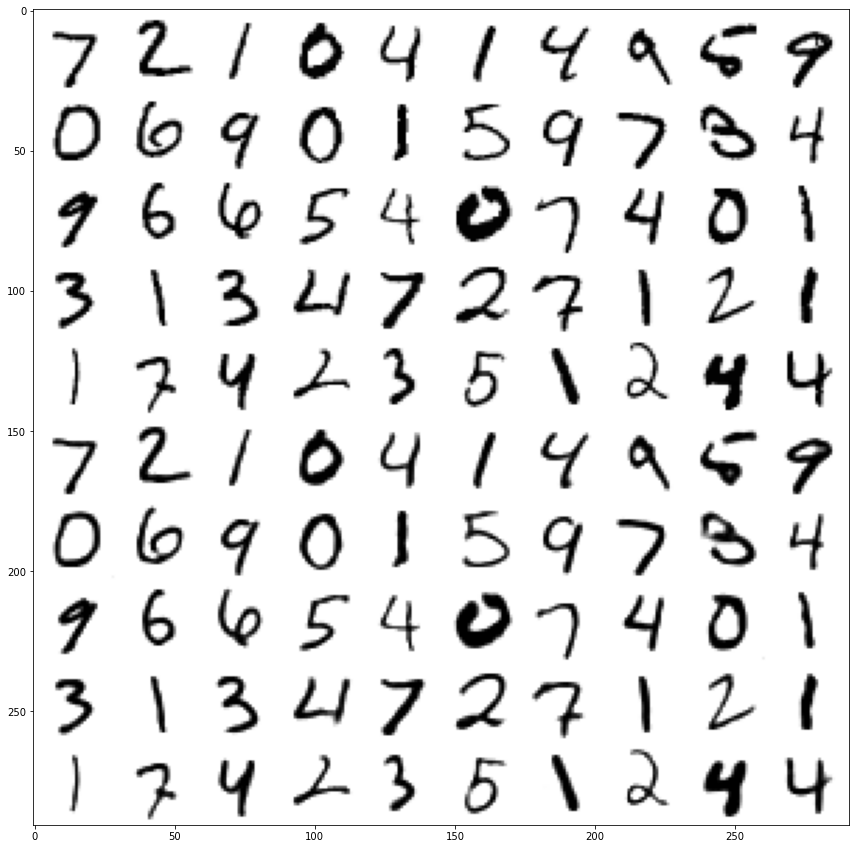

torch.Size([1280, 1, 28, 28])


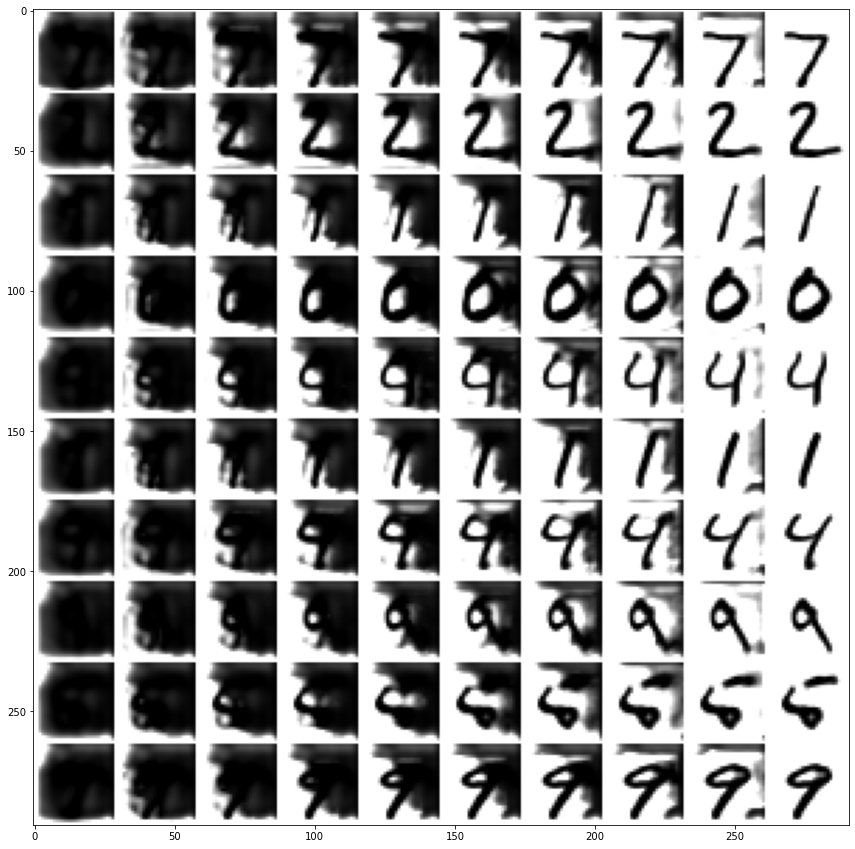

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

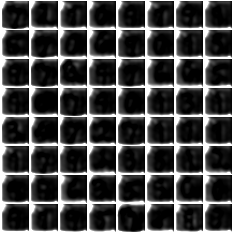

In [9]:
if not os.path.isdir(args.output_dir):
    os.makedirs(args.output_dir)

# plot and save image outputs
img_g = torch.cat((x[:50].to(args.device),torch.sum(c_each,dim=1)[:50]))
img_g = make_grid(img_g, nrow=10, padding=1, normalize=False, pad_value=1)
save_name = 'image_grid_r{}_w{}_steps{}_t{}.png'.format(args.read_size, args.write_size, args.time_steps, args.num_targets)
save_image(img_g, os.path.join(args.output_dir, save_name))
img_g = Image.open(os.path.join(args.output_dir, save_name))
f = plt.figure()
f.set_figheight(15)
f.set_figwidth(15)
plt.imshow(img_g) #matplot imshow() WILL AUTO CHANGE ONE CHANNEL IMG TO COLOR ONE
plt.show()

# reconstructoin steps
c_cumu_step = []
for i in range(args.time_steps):
    c_cumu_step.append(torch.squeeze(torch.cumsum(c_each,dim=1).narrow(1,i,1)))
        
        
num_imgs = 10
images = torch.stack(c_cumu_step, dim=1).view(-1, *args.image_dims)  # reshape to (10*time_steps, 1, 28, 28)
print(images.shape)
images = make_grid(images[0:num_imgs*len(c_cumu_step)], nrow=len(c_cumu_step), padding=1, normalize=False, pad_value=1)
save_name = 'generated_sequences_r{}_w{}_steps{}_t{}.png'.format(args.read_size, args.write_size,args.time_steps,args.num_targets)


save_image(images, os.path.join(args.output_dir, save_name))
images = Image.open(os.path.join(args.output_dir, save_name))
f = plt.figure()
f.set_figheight(15)
f.set_figwidth(15)
plt.imshow(images) #matplot imshow() WILL AUTO CHANGE ONE CHANNEL IMG TO COLOR ONE
plt.show()

# make gif
num_imgs = 64
c_cumu_step_gif = copy.deepcopy(c_cumu_step)
for i in range(len(c_cumu_step)):
    # convert sequence of image tensors to 8x8 grid
    image = make_grid(c_cumu_step[i][:num_imgs].view(-1, *args.image_dims).clip(max=1).cpu(), \
                      nrow=int(math.sqrt(num_imgs)), padding=1, normalize=False, pad_value=1)
    # make into gif
    c_cumu_step_gif[i] = image.data.numpy().transpose(1,2,0)

import imageio
file_add = (os.path.join(args.output_dir, 'generated_{}_time_steps_t{}.gif'.format(args.time_steps, args.num_targets)))
imageio.mimsave(file_add, c_cumu_step_gif)

IP_Image(open(file_add,'rb').read(), width = 600, height = 600)

## Plotting attention windows for all timesteps 

In [ ]:
import matplotlib.gridspec as gridspec

num_trials = 5
idtrial_incorrect = []
save_plot = 0
create_gif = 0
fig_folder = args.output_dir + 'mm_3/'  # folder to save figs/gifs

if args.use_read_attn == False:
    args.read_size = args.image_dims[1]

if args.use_write_attn == False:
    args.write_size = args.image_dims[1]

y_pred_nars = y_pred.narrow(1,0,args.num_classes) 
y_pred_hots, _ , paccs , _, eaccs = cal_accs(y_pred_nars, y.to(args.device), readout_logits, args)

for i in range(num_trials): #len(y)):

    y_true = y[i].cpu()

    if torch.max(y_true) == 1: #len(torch.nonzero(y[i])[0]) > 1:
        y_os = torch.squeeze(torch.nonzero(torch.squeeze(y_true)))
    else:
        y_os = torch.cat( (torch.nonzero(torch.squeeze(y_true))[0], torch.nonzero(torch.squeeze(y_true))[0]))

    y_pred_hot = y_pred_hots[i].cpu()
    y_pred_nar = y_pred_nars[i].cpu()
    if torch.max(y_pred_hot) == 1: #len(torch.nonzero(y[i])[0]) > 1:
        y_pred_os = torch.squeeze(torch.nonzero(torch.squeeze(y_pred_hot)))
    else:
        y_pred_os = torch.cat( (torch.nonzero(torch.squeeze(y_pred_hot))[0], torch.nonzero(torch.squeeze(y_pred_hot))[0]))

    correct_partial = paccs[i].cpu()
    correct_exact = eaccs[i].cpu()

    # print only incorrect trials 
#     if correct_exact == 1:
#         continue 
#     idtrial_incorrect.append(i)
        
    print('\n' + '*'*100)
    print('trial ' + str(i))
        
    print('\nground truth')
    print(y_true)
    print(y_os)
    
    print('model prediction')
    print(y_pred_nar)
    print(y_pred_hot)
    print(y_pred_os)
        
    print(f'partial score, {correct_partial}, exact score, {correct_exact}')
    
        
    g_h = 1
    g_w = 3
    fig = plt.figure(figsize=(15,6))
    gs1 = gridspec.GridSpec(g_h, g_w)
    gs1.update(wspace=0.1, hspace=0.1)  # set the spacing between axes.

    ax = plt.subplot(gs1[0,0])
    ax.imshow(torch.squeeze(x[i].movedim(0,-1)), cmap='gray')
    ax.text(0.5,-0.22,  "Input", size=12, ha="center", transform=ax.transAxes)

    ax = plt.subplot(gs1[0,1])
    ax.imshow(np.squeeze(torch.sum(c_each[i], dim=0).movedim(0,-1).cpu().numpy()), cmap='gray')
    ax.text(0.5,-0.22,  "Reconstruction", size=12, ha="center", transform=ax.transAxes)
    
    ax = plt.subplot(gs1[0,2])
    ax.imshow(np.squeeze(torch.sum(c_each[i], dim=0).movedim(0,-1).cpu().numpy()), vmin=0, vmax=1, cmap='gray')
    ax.text(0.5,-0.22,  "Reconstruction clipped at 1", size=12, ha="center", transform=ax.transAxes)
    
    plt.show()
    

    #--------------------------------------
    # plotting read and  write operatoins 
    
    
    for j in range(args.time_steps):
        
        g_h = 1
        g_w = 5
        fig = plt.figure(figsize=(10,1.5))
        gs1 = gridspec.GridSpec(g_h, g_w)
        gs1.update(wspace=0.1, hspace=0.1)

        class_l = torch.zeros((args.time_steps, args.num_classes+args.backg_objcaps))
    
        ax = plt.subplot(gs1[0,0])
        
#         if args.task == 'MultiMNIST_tracking':
#             print(x[i].shape)
#             x_t = x[i].narrow(0,j,1)
            
#         else:
        x_t = x[i]

        ax.imshow(torch.squeeze(x_t.movedim(0,-1)), vmin=0, vmax=1, cmap='gray')
        ax.axis('off')
        
        ax.text(0.5,1.2,  "Read \nAttention", \
        size=12, ha="center", transform=ax.transAxes)
        
        #if args.use_glimpse_attn:
        if args.use_read_attn:
            mu_x = read_mu_xs[j][i]
            mu_y = read_mu_ys[j][i]

            r_x = mu_x[0]
            r_y = mu_y[0]
            r_w = mu_y[-1] - mu_y[0]
            r_h = mu_x[-1] - mu_x[0]

            ax.add_patch(Rectangle((r_x, r_y), r_w, r_h, facecolor='none', edgecolor='lime', linewidth=2, alpha=0.7))
            #-------------------------------------

#         if args.use_soft_attn:
#             p = j*step_num 
#             soft_map = att_param[p][7][i].cpu().numpy()
            
#             soft_map = np.reshape(soft_map, (8, 8))
#             plt.imshow(soft_map)
#             plt.show()
#             print(len(soft_map))
#             print(soft_map[0].shape)
#             break

            
        ax = plt.subplot(gs1[0,1])
        ax.imshow(read_x_step[i][j].movedim(0,-1).cpu(), cmap='gray')
        ax.axis('off')
        #if j==0:
        ax.text(0.5,1.2,  "Read \nGlimpse", \
        size=12, ha="center", transform=ax.transAxes)
            
        
        #---------------------------------------
        if args.recon_model:
            #im = np.reshape(torch.squeeze(c_cumu_step[j][i]).cpu().numpy(), (args.image_dims[1],args.image_dims[2]))
            im = np.reshape(torch.squeeze(c_cumu_step[j][i]).cpu().numpy(), \
                                (args.image_dims[0], args.image_dims[1],args.image_dims[2])).transpose(1,2,0)

            ax = plt.subplot(gs1[0,3])
            ax.imshow(im, vmin=0, vmax=1 , cmap='gray')  # max(np.max(im),1)
            ax.axis('off')

            #if j==0:
            ax.text(0.5,1.2,  "Cumulative Canvas \nWrite Attention", \
            size=12, ha="center", transform=ax.transAxes)
            
            if args.use_write_attn:
                mu_x = write_mu_xs[j][i]
                mu_y = write_mu_ys[j][i]

                w_x = mu_x[0]
                w_y = mu_y[0]
                w_w = mu_y[-1] - mu_y[0]
                w_h = mu_x[-1] - mu_x[0]

                ax.add_patch(Rectangle((w_x, w_y), w_w, w_h, facecolor='none', edgecolor='red', linewidth=2, alpha=0.7))
                
                c_each = torch.clip(c_each, min=0, max=1)

                ax = plt.subplot(gs1[0,2])
                ax.imshow(c_each[i][j].movedim(0,-1).cpu(), vmin=0, vmax=1, cmap='gray')
                ax.axis('off')
                #if j==0:
                ax.text(0.5,1.2,  "Write \nGlimpse", \
                size=12, ha="center", transform=ax.transAxes)
        
#                 if args.task == 'MultiMNIST_tracking':
#                     x_t = x[i].narrow(0,j+1,1)
#                     ax = plt.subplot(gs1[j,5])
#                     ax.imshow(torch.squeeze(x_t.movedim(0,-1)), vmin=0, vmax=1, cmap='gray')
                        


        if save_plot:
            
            plt.margins(0,0)    
            save_folder = fig_folder + str(i) + '/'
            if not os.path.isdir(save_folder):
                os.makedirs(save_folder)
            fig.savefig( save_folder + 'image{:02d}'.format(j) + '.png', bbox_inches='tight', pad_inches=0.0)

        plt.show()
        
        class_l[j,:] = objcaps_len_step[i][j]
        class_sorted, indices = torch.sort(class_l[j,:], dim=0, descending=True)

        print(class_l[j,:])  # .cpu().numpy()
        print(indices)   # .cpu().numpy()
        #print('_ ' * 40 + '\n')
    
    print('_ ' * 40 + '\n')
    class_l_sum = torch.sum(objcaps_len_step[i],dim=0)
    print(class_l_sum)
    class_sorted_sum, indices_sum = torch.sort(class_l_sum, dim=0, descending=True)
    print(indices_sum)
        
    if save_plot:    
        if create_gif:  

            import imageio
            from PIL import Image
            import glob
            image_list = []
            for filename in glob.glob(save_folder+ '/*.png'): #assuming gif
                im=Image.open(filename)
                image_list.append(np.array(im))


            file_add = (os.path.join(save_folder, 'generated_{}_time_steps_t{}.gif'.format(args.time_steps, args.num_targets)))
            imageio.mimsave(file_add, image_list, duration=0.4)


            #print("The accuracy for this batch is: " + str(test_acc) )

            IP_Image(open(file_add,'rb').read(), width = 600, height = 600)
    
    
    

# Applying the model to controversial Stimuli 

In [13]:
%matplotlib inline 
import matplotlib.pyplot as plt

import pandas as pd
from PIL import Image, ImageOps
import torch
import torch.utils.data as data
from torchvision import datasets
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, TensorDataset

data_dir = './data/' + 'mnist_controversial/'

ex_folder = './PNAS_2020_Controversial_Stimuli-master/experiment_1_results/' 
img_folder = ex_folder + 'stimuli_presented_in_behavioral_experiment/'

data_csv = ex_folder + 'Experiment_1_human_responses.csv'
df = pd.read_csv(data_csv)

subjects = np.unique(df['subject'])

img_names = np.load(data_dir + 'controversial_stimuli_names.npy')

tensor_test_ims = torch.load(data_dir + 'mnist_controversial.pt')

kwargs = {'num_workers': 0, 'pin_memory': True} 

test_dataset = TensorDataset(tensor_test_ims) 
test_dataloader = DataLoader(test_dataset, batch_size=128, **kwargs) # create your dataloader


outPRED = torch.FloatTensor().to(args.device)
L_recon_all = torch.FloatTensor().to(args.device)

# load batch data
for x in test_dataloader:

    x = x[0].to(args.device)
    # evaluate
    
    with torch.no_grad():
        objcaps_len_step, read_x_step, c_step, _ = model(x)
        y_pred = torch.sum(objcaps_len_step, dim=1)
        c = torch.sum(c_step, dim=1)
        # compute loss    
        y_pred_nar = y_pred.narrow(1,0,args.num_classes) # in case a background cap was added, narrow the tensor before passing it to the loss function 

        #loss, L_recon, L_margin = loss_fn(c, c_each_step, recon_mask, x, y_pred_nar, y_pred_nar, args)   

        #clip the predicted cumulative canvas so that the model can overlap object reconstructions without increasing error
        if (args.clip_c):
            c = torch.clip(c,0,1)

        x = x.view(x.shape[0],-1)
        c = c.view(c.shape[0],-1)
        # weight the reconstruction error before adding it to the classification loss
        # loss_f = nn.MSELoss(reduction='none')
        L_recon = args.lam_recon * nn.MSELoss(reduction='none')(c, x)  
        L_recon = torch.mean(L_recon, dim=1)

        #loss, L_recon, L_margin = loss_fn(c, c_each_step, recon_mask, x, y_pred_nar, y_pred_nar, args)   

        #c = torch.reshape(torch.clip(c,0,1).detach(), (1, *args.image_dims))   #to plot

        outPRED = torch.cat((outPRED, y_pred_nar), 0)
        L_recon_all = torch.cat((L_recon_all, L_recon), 0)
    

c_factor = torch.zeros_like(L_recon_all)

# for i in range(len(L_recon_all)):
#     if L_recon_all[i] < 0.6:
#         c_factor[i] = 1
#     else:
#         c_factor[i] = 0


        
for i in range(len(L_recon_all)):
    if L_recon_all[i] < 0.1:
        c_factor[i] = 1
    elif L_recon_all[i] > 0.6:
        c_factor[i] = 0
    else:
        c_factor[i] = 1 - (2* (L_recon_all[i] - 0.1))
        
        

y_preds = 2 * (torch.clip(outPRED,.5,1)  - 0.5)

y_preds = torch.unsqueeze(c_factor, 1).expand(-1,10) * y_preds

y_preds = torch.reshape(y_preds.detach(), (-1,)).cpu().numpy()
np.mean(y_preds)

model_data = {'image':np.repeat(img_names,10),
        'category':np.tile([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],len(img_names)),
        'predictions':y_preds}

model_df = pd.DataFrame(model_data)


r_ms_all = np.zeros(len(subjects))
for i in range(30): #len(subjects)):
    
    sub_name = subjects[i]

    df_s = df[ (df['subject']==sub_name) & (df['image_repetition']==0)]
    df_sm= pd.merge(df_s, model_df, on=['image','category'], how='inner')

    sub_r = df_sm['rating'].to_numpy()
    model_p = df_sm['predictions'].to_numpy()
    
    denom = np.sqrt(np.sum(np.square(sub_r - np.mean(sub_r)))) * np.sqrt(np.sum(np.square(model_p - np.mean(model_p))))
    r_ms = np.sum ( (sub_r - np.mean(sub_r)) * (model_p - np.mean(model_p)) ) / denom
    
    r_ms_all[i] = r_ms
    
    
# L_recon_all  = L_recon_all.detach().cpu().numpy()
# outPRED = outPRED

print(r_ms_all)
    
print('average correlation')
print(np.mean(r_ms_all))

[0.81503597 0.76957006 0.65810042 0.77247262 0.75756945 0.8198974
 0.81938688 0.75800205 0.75672258 0.78309135 0.75487218 0.70022936
 0.75247416 0.8284136  0.82604563 0.70051018 0.8137715  0.80981805
 0.82377844 0.79445728 0.77135477 0.76061221 0.80178787 0.77872214
 0.80394123 0.78947197 0.81854884 0.80110922 0.83246817 0.77675488]
average correlation
0.7816330152162843


madry_adv_trained_3_small_VGG_negative_6
tensor([[0.6680, 0.5217, 0.2327, 0.2561, 0.5227, 0.4774, 0.4563, 0.0469, 0.6051,
         0.3254]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([13.0681], device='cuda:0')
tensor([0.], device='cuda:0')


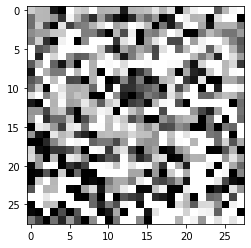

madry_adv_trained_3_small_VGG_negative_8
tensor([[0.6205, 0.3484, 0.1138, 0.4007, 0.1692, 0.4498, 0.1165, 0.0690, 0.9762,
         0.1969]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([12.6734], device='cuda:0')
tensor([0.], device='cuda:0')


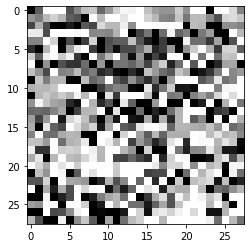

madry_adv_trained_4_madry_l2_2
tensor([[1.2129, 0.1003, 1.1952, 1.5393, 0.3188, 0.7859, 0.3599, 0.6628, 1.9402,
         0.3318]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([13.9197], device='cuda:0')
tensor([0.], device='cuda:0')


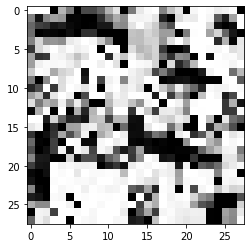

madry_adv_trained_4_madry_l2_3
tensor([[0.5672, 0.0768, 0.4141, 1.3868, 0.6676, 0.0837, 0.0936, 0.1275, 0.4775,
         0.0471]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([10.5219], device='cuda:0')
tensor([0.], device='cuda:0')


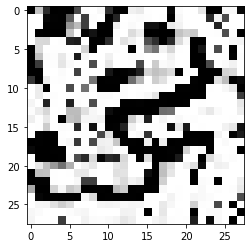

madry_adv_trained_4_schott_VAE_1
tensor([[0.0181, 1.4302, 0.0026, 0.0037, 0.0956, 0.0062, 0.0035, 0.0861, 0.0396,
         0.0801]], device='cuda:0')
[0.        0.5529674 0.        0.        0.        0.        0.
 0.        0.        0.       ]
[0.   0.25 0.   0.   0.   0.   0.   0.   0.   0.  ]
tensor([0.3235], device='cuda:0')
tensor([0.5530], device='cuda:0')


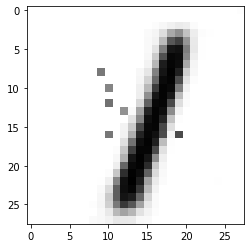

madry_adv_trained_4_schott_VAE_7
tensor([[0.0321, 0.0141, 0.0025, 0.0049, 0.0089, 0.0077, 0.0027, 1.5287, 0.0056,
         0.0878]], device='cuda:0')
[0.         0.         0.         0.         0.         0.
 0.         0.69742954 0.         0.        ]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
tensor([0.2513], device='cuda:0')
tensor([0.6974], device='cuda:0')


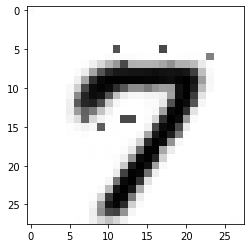

madry_adv_trained_4_small_VGG_6
tensor([[0.6573, 0.0932, 0.1596, 0.0980, 0.4098, 0.6330, 0.6518, 0.0284, 0.4444,
         0.1815]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([10.3243], device='cuda:0')
tensor([0.], device='cuda:0')


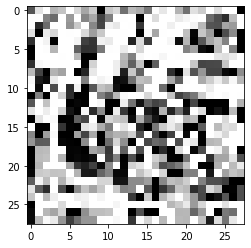

madry_adv_trained_4_small_VGG_8
tensor([[0.7375, 0.2984, 0.4396, 0.1228, 0.2884, 0.8107, 0.2761, 0.2279, 0.7111,
         0.3754]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([12.1490], device='cuda:0')
tensor([0.], device='cuda:0')


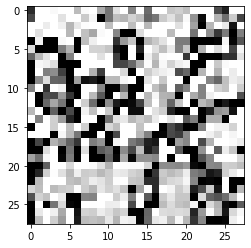

madry_adv_trained_4_small_VGG_negative_6
tensor([[0.3960, 0.4674, 0.2744, 0.3834, 0.4350, 1.0111, 0.1966, 0.0911, 1.0140,
         0.3238]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([11.7425], device='cuda:0')
tensor([0.], device='cuda:0')


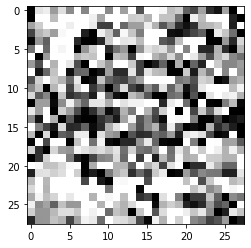

madry_adv_trained_4_small_VGG_negative_7
tensor([[0.5029, 0.4973, 0.1475, 0.2215, 0.5006, 0.4630, 0.1587, 0.1253, 0.5070,
         0.3733]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([10.7093], device='cuda:0')
tensor([0.], device='cuda:0')


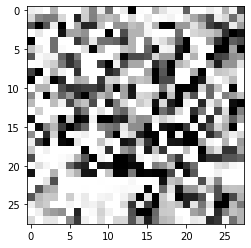

madry_adv_trained_5_madry_l2_3
tensor([[1.2491, 0.0426, 0.3249, 0.5003, 0.1004, 0.2188, 0.1626, 0.3658, 0.1140,
         0.0618]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.   0.   0.   0.   0.   0.   0.   0.25 0.   0.  ]
tensor([10.6232], device='cuda:0')
tensor([0.], device='cuda:0')


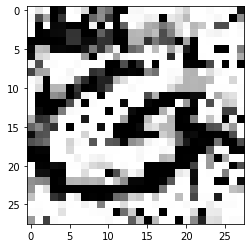

madry_adv_trained_5_madry_l2_9
tensor([[0.4878, 0.1345, 0.2114, 0.6004, 0.1185, 0.3008, 0.3789, 0.0933, 1.3837,
         0.4442]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([10.8872], device='cuda:0')
tensor([0.], device='cuda:0')


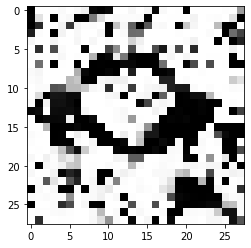

madry_adv_trained_5_schott_VAE_1
tensor([[0.0032, 1.7072, 0.0045, 0.0141, 0.0603, 0.0692, 0.0036, 0.0219, 0.0054,
         0.0239]], device='cuda:0')
[0.        0.7605251 0.        0.        0.        0.        0.
 0.        0.        0.       ]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([0.2197], device='cuda:0')
tensor([0.7605], device='cuda:0')


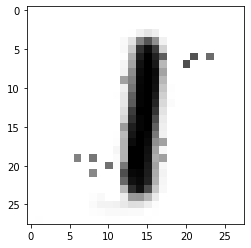

madry_adv_trained_5_schott_VAE_3
tensor([[5.2249e-03, 2.2223e-03, 3.1557e-03, 1.4528e+00, 4.5869e-03, 2.3217e-02,
         1.2133e-03, 8.7144e-03, 3.4701e-02, 7.2773e-03]], device='cuda:0')
[0.         0.         0.         0.39498812 0.         0.
 0.         0.         0.         0.        ]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
tensor([0.4025], device='cuda:0')
tensor([0.3950], device='cuda:0')


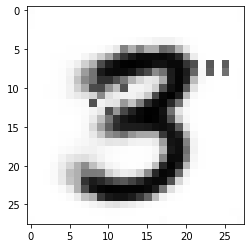

madry_adv_trained_5_small_VGG_3
tensor([[0.4090, 0.1057, 0.6732, 0.4365, 0.2774, 0.6035, 0.2638, 0.0526, 1.3074,
         0.3627]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.   0.   0.   0.25 0.   0.   0.25 0.   0.   0.  ]
tensor([11.9913], device='cuda:0')
tensor([0.], device='cuda:0')


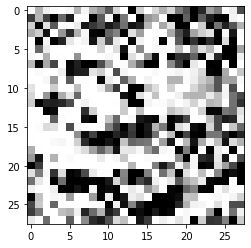

madry_adv_trained_5_small_VGG_9
tensor([[0.4213, 0.1294, 0.7338, 0.3368, 0.1406, 1.0068, 0.4087, 0.0842, 0.4084,
         0.2861]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([12.2530], device='cuda:0')
tensor([0.], device='cuda:0')


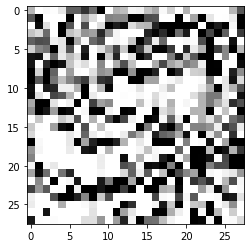

madry_adv_trained_5_small_VGG_negative_2
tensor([[0.9042, 0.1257, 0.1909, 0.0969, 0.1036, 0.9071, 0.3669, 0.0755, 0.7915,
         0.1437]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([13.6481], device='cuda:0')
tensor([0.], device='cuda:0')


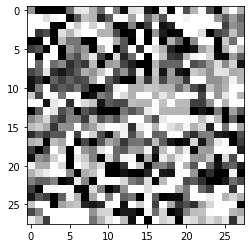

madry_adv_trained_5_small_VGG_negative_3
tensor([[0.8753, 0.2867, 0.3581, 0.7144, 0.2678, 0.7165, 0.1686, 0.0821, 0.6531,
         0.3304]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([12.2487], device='cuda:0')
tensor([0.], device='cuda:0')


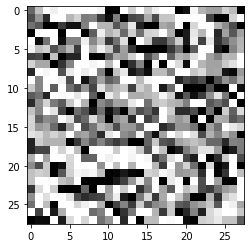

madry_adv_trained_6_madry_l2_4
tensor([[1.3546, 0.2920, 0.2704, 1.0495, 0.4248, 1.3135, 0.4043, 0.2328, 1.4587,
         0.1347]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([12.9251], device='cuda:0')
tensor([0.], device='cuda:0')


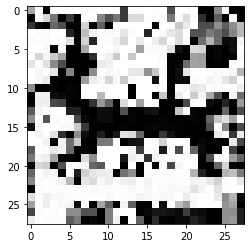

madry_adv_trained_6_madry_l2_7
tensor([[0.9667, 0.2036, 0.9733, 0.5936, 0.0836, 0.2212, 0.6847, 1.0893, 0.2754,
         0.0860]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([12.9517], device='cuda:0')
tensor([0.], device='cuda:0')


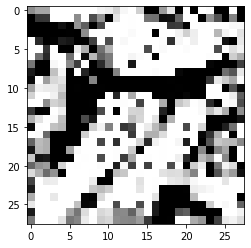

madry_adv_trained_6_schott_VAE_5
tensor([[0.0068, 0.0060, 0.0040, 0.0043, 0.0098, 1.2779, 0.0265, 0.0017, 0.0050,
         0.0119]], device='cuda:0')
[0.         0.         0.         0.         0.         0.74133974
 0.         0.         0.         0.        ]
[0.   0.   0.   0.   0.   0.75 0.25 0.   0.   0.  ]
tensor([0.2293], device='cuda:0')
tensor([0.7413], device='cuda:0')


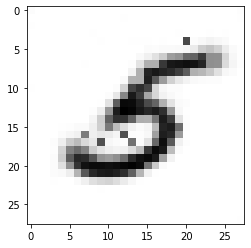

madry_adv_trained_6_schott_VAE_8
tensor([[2.4661e-03, 1.0678e-03, 3.8925e-03, 4.0115e-03, 2.8371e-03, 3.8225e-03,
         3.5349e-03, 1.3111e-03, 1.7638e+00, 1.0791e-02]], device='cuda:0')
[0.        0.        0.        0.        0.        0.        0.
 0.        0.6413732 0.       ]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
tensor([0.2793], device='cuda:0')
tensor([0.6414], device='cuda:0')


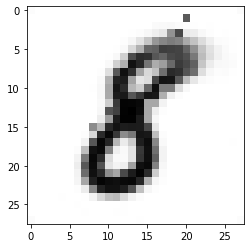

madry_adv_trained_6_small_VGG_0
tensor([[1.8154, 0.1168, 0.1201, 0.2644, 0.2454, 0.4849, 0.4662, 0.1215, 0.4553,
         0.2196]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([13.5043], device='cuda:0')
tensor([0.], device='cuda:0')


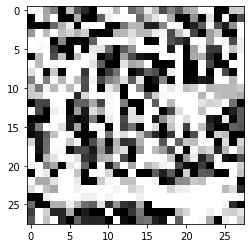

madry_adv_trained_6_small_VGG_4
tensor([[0.6225, 0.0215, 0.2549, 0.0566, 0.6605, 0.2443, 0.3125, 0.0938, 0.2346,
         0.2220]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([10.3447], device='cuda:0')
tensor([0.], device='cuda:0')


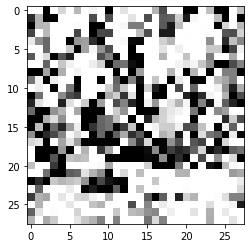

madry_adv_trained_6_small_VGG_negative_0
tensor([[1.7963, 0.5270, 0.0640, 0.1780, 0.2087, 1.3173, 0.6356, 0.2358, 1.6189,
         0.2016]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([13.9516], device='cuda:0')
tensor([0.], device='cuda:0')


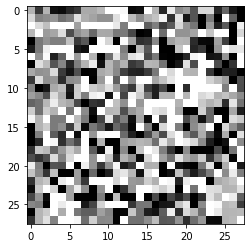

madry_adv_trained_6_small_VGG_negative_5
tensor([[0.6711, 0.5080, 0.1759, 0.0836, 0.2813, 0.3733, 0.1836, 0.0481, 0.3259,
         0.3259]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([13.2337], device='cuda:0')
tensor([0.], device='cuda:0')


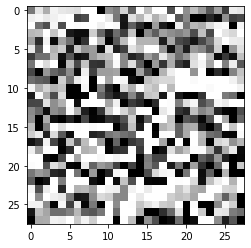

madry_adv_trained_7_madry_l2_0
tensor([[1.5147, 0.1574, 0.3210, 0.8520, 0.3274, 0.4818, 0.4585, 0.3585, 1.0756,
         0.3393]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([11.9790], device='cuda:0')
tensor([0.], device='cuda:0')


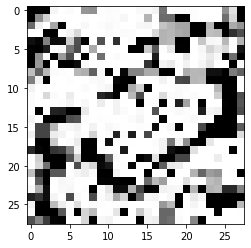

madry_adv_trained_7_madry_l2_8
tensor([[0.1477, 0.0754, 0.3019, 0.8785, 0.3605, 0.1167, 0.1535, 0.1864, 1.9997,
         0.3360]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([10.6035], device='cuda:0')
tensor([0.], device='cuda:0')


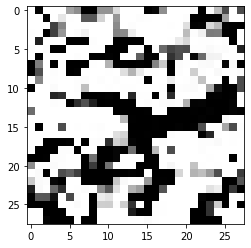

madry_adv_trained_7_schott_VAE_4
tensor([[3.2652e-03, 5.4746e-03, 1.3629e-03, 1.1471e-03, 1.8316e+00, 1.4430e-02,
         1.1578e-02, 5.4021e-03, 1.8909e-03, 2.1483e-02]], device='cuda:0')
[0.         0.         0.         0.         0.44619268 0.
 0.         0.         0.         0.        ]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
tensor([0.3769], device='cuda:0')
tensor([0.4462], device='cuda:0')


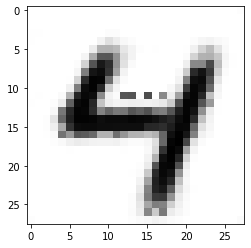

madry_adv_trained_7_schott_VAE_9
tensor([[0.0076, 0.0122, 0.0153, 0.0098, 0.0917, 0.0048, 0.0026, 0.0342, 0.0107,
         1.3971]], device='cuda:0')
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.6003341]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
tensor([0.2998], device='cuda:0')
tensor([0.6003], device='cuda:0')


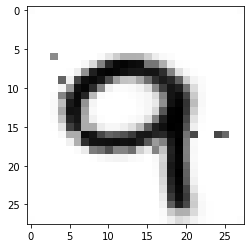

madry_adv_trained_7_small_VGG_5
tensor([[1.1147, 0.1272, 0.4202, 0.5292, 0.2527, 0.8032, 0.3347, 0.3557, 0.6523,
         0.2961]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([12.3528], device='cuda:0')
tensor([0.], device='cuda:0')


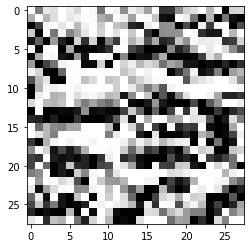

madry_adv_trained_7_small_VGG_6
tensor([[0.4532, 0.0664, 0.3156, 0.3391, 0.5204, 0.3445, 1.8176, 0.1428, 0.2058,
         0.2424]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([11.3272], device='cuda:0')
tensor([0.], device='cuda:0')


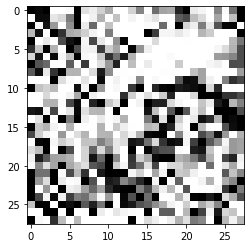

madry_adv_trained_7_small_VGG_negative_2
tensor([[0.5184, 0.2118, 0.1666, 0.1719, 0.3212, 0.4865, 0.1356, 0.0506, 0.8436,
         0.3258]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([13.0588], device='cuda:0')
tensor([0.], device='cuda:0')


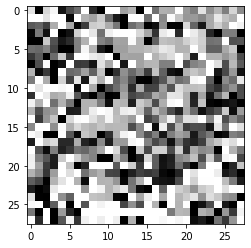

madry_adv_trained_7_small_VGG_negative_4
tensor([[1.3986, 1.1845, 0.0659, 0.1595, 0.1507, 0.9183, 0.3327, 0.3045, 0.5677,
         0.1757]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([13.8351], device='cuda:0')
tensor([0.], device='cuda:0')


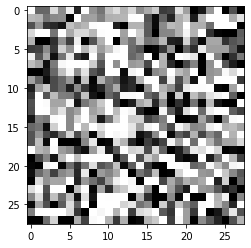

madry_adv_trained_8_madry_l2_5
tensor([[1.0668, 0.0617, 0.1430, 0.2384, 0.4153, 0.9125, 0.3247, 0.1274, 0.4078,
         0.4085]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([11.7579], device='cuda:0')
tensor([0.], device='cuda:0')


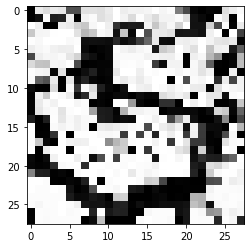

madry_adv_trained_8_madry_l2_7
tensor([[1.6815, 0.2289, 0.6099, 0.6113, 0.0760, 0.3363, 0.4163, 0.9883, 0.7053,
         0.2531]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([13.7085], device='cuda:0')
tensor([0.], device='cuda:0')


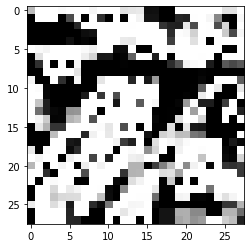

madry_adv_trained_8_schott_VAE_4
tensor([[0.0052, 0.0092, 0.0029, 0.0045, 1.4966, 0.0161, 0.0079, 0.0064, 0.0034,
         0.0228]], device='cuda:0')
[0.         0.         0.         0.         0.70100987 0.
 0.         0.         0.         0.        ]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
tensor([0.2495], device='cuda:0')
tensor([0.7010], device='cuda:0')


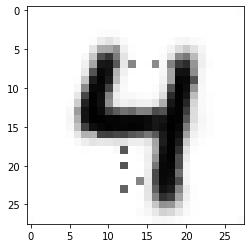

madry_adv_trained_8_schott_VAE_5
tensor([[0.0034, 0.0021, 0.0019, 0.0197, 0.0080, 1.3874, 0.0048, 0.0035, 0.0110,
         0.0134]], device='cuda:0')
[0.         0.         0.         0.         0.         0.48079175
 0.         0.         0.         0.        ]
[0.  0.  0.  0.  0.  0.5 0.  0.  0.5 0. ]
tensor([0.3596], device='cuda:0')
tensor([0.4808], device='cuda:0')


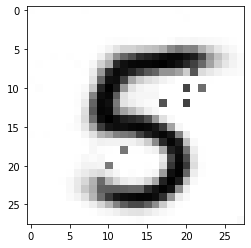

madry_adv_trained_8_small_VGG_5
tensor([[1.0928, 0.3268, 0.3766, 0.3020, 0.2161, 0.3370, 0.1640, 0.3140, 0.4672,
         0.6074]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([13.4223], device='cuda:0')
tensor([0.], device='cuda:0')


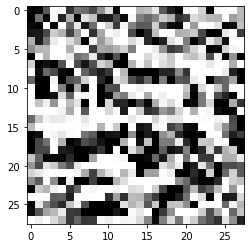

madry_adv_trained_8_small_VGG_7
tensor([[1.3068, 0.2923, 0.6171, 0.4577, 0.2158, 0.4938, 0.1770, 0.1196, 0.8813,
         0.5432]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([13.0202], device='cuda:0')
tensor([0.], device='cuda:0')


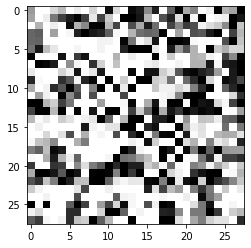

madry_adv_trained_8_small_VGG_negative_1
tensor([[0.3657, 0.5674, 0.9025, 0.1656, 0.1571, 0.1373, 0.2860, 0.0150, 0.4990,
         0.2344]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([12.1357], device='cuda:0')
tensor([0.], device='cuda:0')


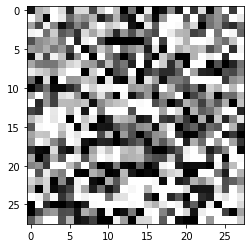

madry_adv_trained_8_small_VGG_negative_9
tensor([[0.6625, 0.1250, 0.3440, 0.2595, 0.2134, 0.0828, 0.0968, 0.0263, 0.5430,
         0.1539]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([12.4730], device='cuda:0')
tensor([0.], device='cuda:0')


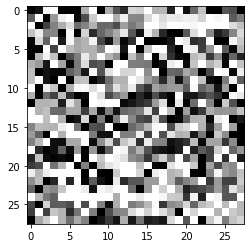

madry_adv_trained_9_madry_l2_1
tensor([[0.8878, 0.1667, 0.7843, 0.5462, 0.1845, 0.4940, 0.5634, 0.4522, 0.7455,
         0.4902]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.   0.   0.   0.25 0.   0.   0.25 0.   0.   0.  ]
tensor([11.9171], device='cuda:0')
tensor([0.], device='cuda:0')


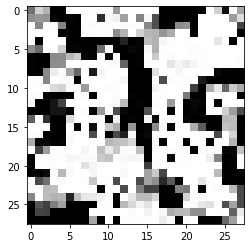

madry_adv_trained_9_madry_l2_4
tensor([[0.2093, 0.2376, 0.2123, 0.2651, 1.1997, 0.6078, 0.0569, 0.0700, 1.1816,
         0.1823]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([8.7783], device='cuda:0')
tensor([0.], device='cuda:0')


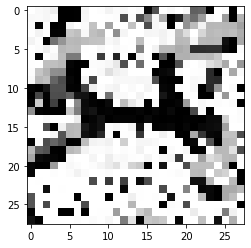

madry_adv_trained_9_schott_VAE_0
tensor([[1.9681, 0.0121, 0.0157, 0.0042, 0.0039, 0.0101, 0.0083, 0.0116, 0.0065,
         0.0124]], device='cuda:0')
[0.38541782 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([0.4073], device='cuda:0')
tensor([0.3854], device='cuda:0')


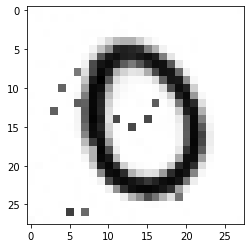

madry_adv_trained_9_schott_VAE_2
tensor([[0.0150, 0.0139, 1.9375, 0.0345, 0.0147, 0.0339, 0.0231, 0.0822, 0.0512,
         0.0186]], device='cuda:0')
[0.         0.         0.23936355 0.         0.         0.
 0.         0.         0.         0.        ]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
tensor([0.4803], device='cuda:0')
tensor([0.2394], device='cuda:0')


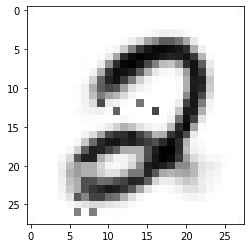

madry_adv_trained_9_small_VGG_1
tensor([[0.5136, 0.3352, 0.3755, 0.2842, 0.3370, 0.3223, 0.1262, 0.3001, 0.5733,
         0.2289]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.   0.   0.   0.   0.25 0.   0.   0.   0.   0.  ]
tensor([11.8506], device='cuda:0')
tensor([0.], device='cuda:0')


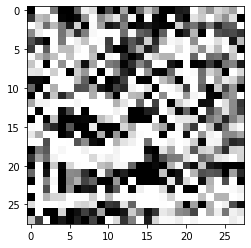

madry_adv_trained_9_small_VGG_2
tensor([[0.3772, 0.2202, 0.5200, 0.8669, 0.4924, 0.6222, 0.4884, 0.1149, 0.9922,
         0.4167]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([12.3532], device='cuda:0')
tensor([0.], device='cuda:0')


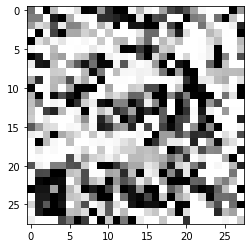

madry_adv_trained_9_small_VGG_negative_0
tensor([[0.6760, 1.0451, 0.0602, 0.2866, 0.1535, 0.6454, 0.1331, 0.0492, 0.9123,
         0.3466]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([13.0980], device='cuda:0')
tensor([0.], device='cuda:0')


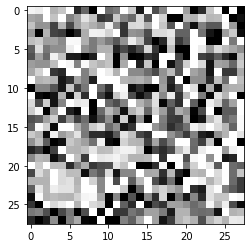

madry_adv_trained_9_small_VGG_negative_1
tensor([[1.1234, 0.6750, 0.2291, 0.3629, 0.2482, 0.5479, 0.1499, 0.1181, 0.3837,
         0.3078]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([12.8369], device='cuda:0')
tensor([0.], device='cuda:0')


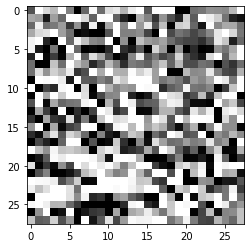

madry_l2_0_schott_VAE_5
tensor([[0.0510, 0.0090, 0.0133, 0.1175, 0.0121, 1.1886, 0.0190, 0.0169, 0.0185,
         0.0161]], device='cuda:0')
[0.         0.         0.         0.         0.         0.64810026
 0.         0.         0.         0.        ]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
tensor([0.2759], device='cuda:0')
tensor([0.6481], device='cuda:0')


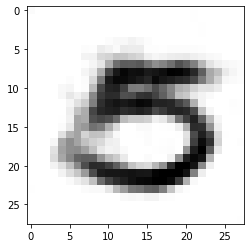

madry_l2_0_schott_VAE_9
tensor([[0.4596, 0.0113, 0.0129, 0.0232, 0.0531, 0.0271, 0.1373, 0.0173, 0.0624,
         0.8371]], device='cuda:0')
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.2622452]
[0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
tensor([0.4055], device='cuda:0')
tensor([0.3890], device='cuda:0')


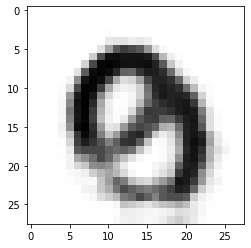

madry_l2_0_small_VGG_4
tensor([[1.0451, 0.2449, 0.6926, 0.2508, 0.9338, 0.1680, 0.5820, 0.0727, 0.8084,
         0.4892]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([13.5177], device='cuda:0')
tensor([0.], device='cuda:0')


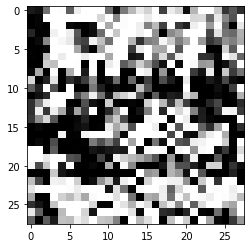

madry_l2_0_small_VGG_6
tensor([[2.3190, 0.2222, 0.4819, 0.3141, 0.4299, 0.4364, 1.0489, 0.1671, 0.7423,
         0.3167]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([15.1249], device='cuda:0')
tensor([0.], device='cuda:0')


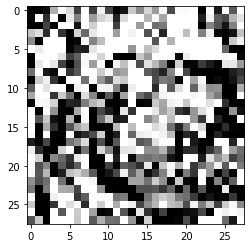

madry_l2_0_small_VGG_negative_4
tensor([[1.3430, 1.0043, 0.2475, 0.2328, 0.1555, 0.2787, 0.0979, 0.0898, 0.8859,
         0.2398]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([13.2578], device='cuda:0')
tensor([0.], device='cuda:0')


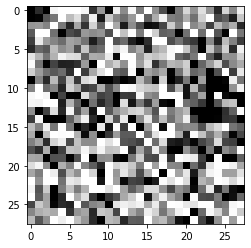

madry_l2_0_small_VGG_negative_6
tensor([[1.3934, 1.1963, 0.1798, 0.4078, 0.1258, 0.8514, 0.6235, 0.1559, 1.2410,
         0.2404]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([15.5721], device='cuda:0')
tensor([0.], device='cuda:0')


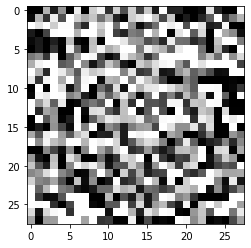

madry_l2_1_schott_VAE_7
tensor([[0.0700, 0.0974, 0.0844, 0.0303, 0.0059, 0.0136, 0.0022, 1.8735, 0.0407,
         0.0649]], device='cuda:0')
[0.         0.         0.         0.         0.         0.
 0.         0.50480866 0.         0.        ]
[0.   0.25 0.   0.   0.   0.   0.   0.75 0.   0.  ]
tensor([0.3476], device='cuda:0')
tensor([0.5048], device='cuda:0')


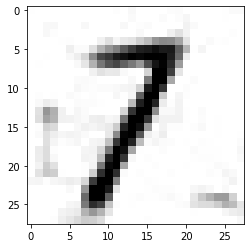

madry_l2_1_schott_VAE_8
tensor([[0.0293, 0.3196, 0.2240, 0.1871, 0.0617, 0.0096, 0.0665, 0.0308, 1.3330,
         0.0175]], device='cuda:0')
[0.        0.        0.        0.        0.        0.        0.
 0.        0.6153557 0.       ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([0.2923], device='cuda:0')
tensor([0.6154], device='cuda:0')


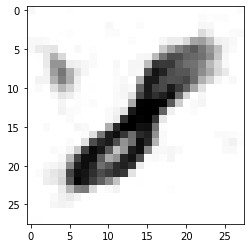

madry_l2_1_small_VGG_4
tensor([[0.5713, 0.1932, 0.4240, 0.2193, 1.4452, 0.1553, 0.1775, 0.1529, 0.7610,
         0.1985]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([13.0101], device='cuda:0')
tensor([0.], device='cuda:0')


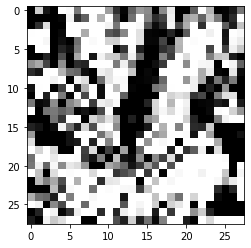

madry_l2_1_small_VGG_8
tensor([[2.2242, 0.3159, 0.5890, 0.6653, 0.5792, 1.8608, 0.9462, 0.6594, 1.4610,
         0.8871]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([15.4892], device='cuda:0')
tensor([0.], device='cuda:0')


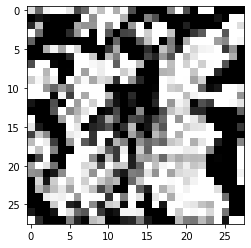

madry_l2_1_small_VGG_negative_2
tensor([[1.6555, 0.9768, 0.4098, 0.7507, 0.1928, 1.3230, 0.7106, 0.3221, 1.3250,
         0.1812]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([16.4052], device='cuda:0')
tensor([0.], device='cuda:0')


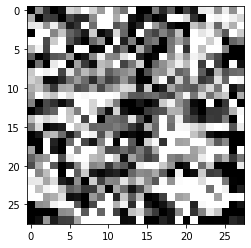

madry_l2_1_small_VGG_negative_7
tensor([[1.0898, 1.4239, 0.4469, 0.3830, 0.3081, 0.9046, 0.3448, 0.4055, 0.8077,
         0.4604]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([13.5034], device='cuda:0')
tensor([0.], device='cuda:0')


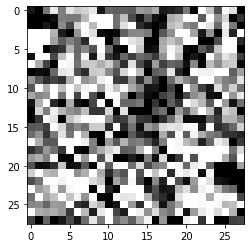

madry_l2_2_schott_VAE_0
tensor([[1.9479, 0.0070, 0.0938, 0.0142, 0.0107, 0.0123, 0.0338, 0.0414, 0.0049,
         0.0396]], device='cuda:0')
[0.08006865 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([0.5600], device='cuda:0')
tensor([0.0801], device='cuda:0')


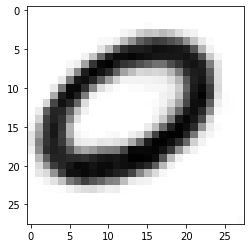

madry_l2_2_schott_VAE_3
tensor([[0.0749, 0.0335, 0.1594, 1.2524, 0.0062, 0.0587, 0.0445, 0.0196, 0.0684,
         0.0129]], device='cuda:0')
[0.        0.        0.        0.4284085 0.        0.        0.
 0.        0.        0.       ]
[0.   0.   0.25 0.75 0.   0.   0.   0.   0.   0.  ]
tensor([0.3858], device='cuda:0')
tensor([0.4284], device='cuda:0')


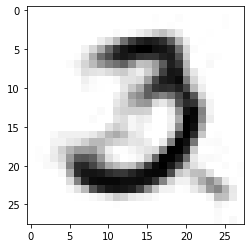

madry_l2_2_small_VGG_0
tensor([[1.6820, 0.3694, 0.9991, 0.8426, 1.0970, 1.8242, 0.4005, 0.7059, 0.5439,
         0.6270]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([19.0257], device='cuda:0')
tensor([0.], device='cuda:0')


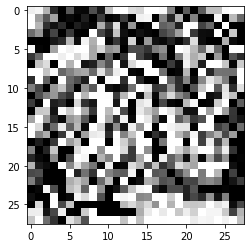

madry_l2_2_small_VGG_5
tensor([[1.4290, 0.6983, 0.2778, 0.0932, 0.3669, 0.6396, 0.2710, 0.1289, 0.5319,
         0.5079]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([16.4964], device='cuda:0')
tensor([0.], device='cuda:0')


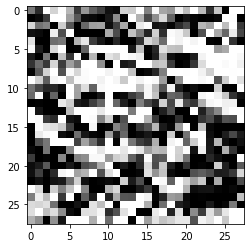

madry_l2_2_small_VGG_negative_0
tensor([[1.8006, 1.0144, 0.1755, 0.1873, 0.3187, 0.4611, 0.2125, 0.1246, 0.5675,
         0.2540]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([14.4178], device='cuda:0')
tensor([0.], device='cuda:0')


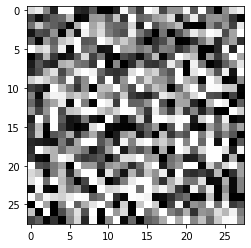

madry_l2_2_small_VGG_negative_9
tensor([[0.3582, 1.3566, 0.3966, 0.3315, 0.1136, 0.9658, 0.4651, 0.0533, 0.6091,
         0.1555]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([15.9353], device='cuda:0')
tensor([0.], device='cuda:0')


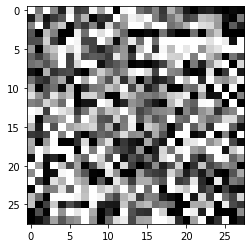

madry_l2_3_schott_VAE_2
tensor([[0.0344, 0.0421, 0.9930, 0.4697, 0.0211, 0.0194, 0.0180, 0.1202, 0.3431,
         0.0739]], device='cuda:0')
[0.         0.         0.22645953 0.         0.         0.
 0.         0.         0.         0.        ]
[0.  0.  0.5 0.  0.  0.  0.  0.  0.5 0. ]
tensor([0.4852], device='cuda:0')
tensor([0.2297], device='cuda:0')


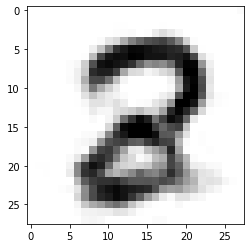

madry_l2_3_schott_VAE_9
tensor([[0.0181, 0.0186, 0.0391, 0.1331, 0.0370, 0.0286, 0.0064, 0.0318, 0.0848,
         1.7417]], device='cuda:0')
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.6301954]
[0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.75]
tensor([0.2849], device='cuda:0')
tensor([0.6302], device='cuda:0')


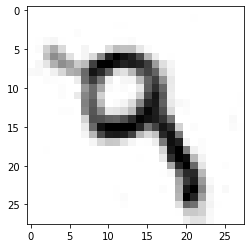

madry_l2_3_small_VGG_1
tensor([[0.7700, 0.5156, 0.3108, 0.6848, 0.1547, 0.6210, 0.1637, 0.1342, 0.6621,
         0.4585]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.  ]
tensor([16.0123], device='cuda:0')
tensor([0.], device='cuda:0')


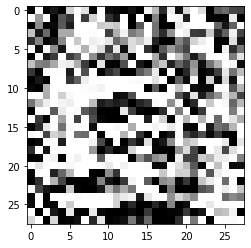

madry_l2_3_small_VGG_9
tensor([[0.9584, 0.2082, 0.2928, 1.0638, 0.3921, 0.4646, 0.1120, 0.2032, 0.1850,
         0.3653]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([12.4900], device='cuda:0')
tensor([0.], device='cuda:0')


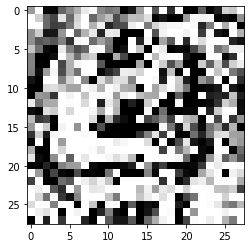

madry_l2_3_small_VGG_negative_1
tensor([[0.2126, 0.7277, 0.5146, 1.0014, 0.2631, 0.4965, 0.1363, 0.1036, 0.5294,
         0.3811]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([12.9350], device='cuda:0')
tensor([0.], device='cuda:0')


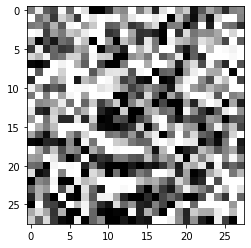

madry_l2_3_small_VGG_negative_6
tensor([[0.3545, 0.1596, 0.7665, 0.5935, 0.1446, 0.1345, 0.1910, 0.0794, 0.3272,
         0.2377]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([12.0295], device='cuda:0')
tensor([0.], device='cuda:0')


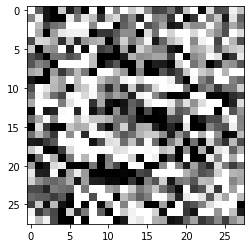

madry_l2_4_schott_VAE_1
tensor([[0.0084, 1.5769, 0.0038, 0.0027, 0.2934, 0.0084, 0.0049, 0.3018, 0.0090,
         0.1611]], device='cuda:0')
[0.         0.25225586 0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.   0.25 0.   0.   0.75 0.   0.   0.   0.   0.  ]
tensor([0.4739], device='cuda:0')
tensor([0.2523], device='cuda:0')


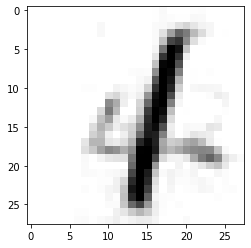

madry_l2_4_schott_VAE_7
tensor([[0.0724, 0.1396, 0.0077, 0.0217, 0.3152, 0.1166, 0.0174, 0.5539, 0.0300,
         0.4843]], device='cuda:0')
[0.        0.        0.        0.        0.        0.        0.
 0.0564125 0.        0.       ]
[0.   0.   0.   0.   0.75 0.   0.   0.   0.   0.  ]
tensor([0.3384], device='cuda:0')
tensor([0.5233], device='cuda:0')


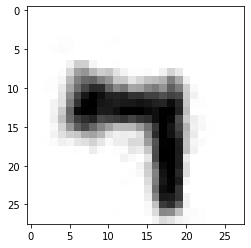

madry_l2_4_small_VGG_1
tensor([[0.2853, 0.1455, 0.5714, 1.4299, 0.4691, 0.5442, 0.1097, 0.0796, 1.4022,
         0.1881]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([14.8156], device='cuda:0')
tensor([0.], device='cuda:0')


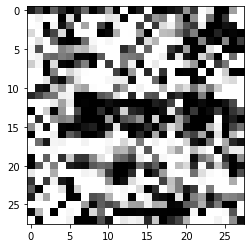

madry_l2_4_small_VGG_2
tensor([[1.0207, 0.0144, 0.4524, 0.4336, 0.4639, 0.4941, 0.1972, 0.2866, 1.3452,
         0.1261]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([13.6873], device='cuda:0')
tensor([0.], device='cuda:0')


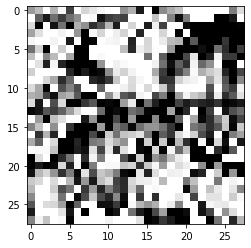

madry_l2_4_small_VGG_negative_5
tensor([[0.6643, 0.1166, 0.2399, 0.4302, 0.2213, 0.4915, 0.2219, 0.0783, 1.5389,
         0.1837]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([13.9024], device='cuda:0')
tensor([0.], device='cuda:0')


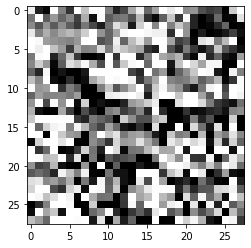

madry_l2_4_small_VGG_negative_8
tensor([[1.4356, 0.6330, 0.4274, 0.8228, 0.2682, 0.9392, 0.5482, 0.1586, 1.7198,
         0.1741]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([14.1917], device='cuda:0')
tensor([0.], device='cuda:0')


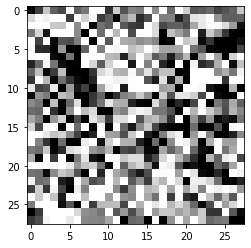

madry_l2_5_schott_VAE_4
tensor([[0.0315, 0.0095, 0.0032, 0.0144, 1.3004, 0.3547, 0.0351, 0.0324, 0.0112,
         0.0675]], device='cuda:0')
[0.         0.         0.         0.         0.56440365 0.
 0.         0.         0.         0.        ]
[0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
tensor([0.3178], device='cuda:0')
tensor([0.5644], device='cuda:0')


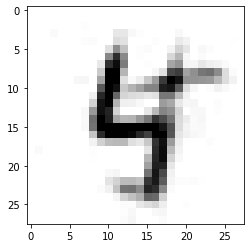

madry_l2_5_schott_VAE_6
tensor([[0.1269, 0.0039, 0.0427, 0.0218, 0.0457, 0.4163, 0.9650, 0.0018, 0.0906,
         0.0225]], device='cuda:0')
[0.         0.         0.         0.         0.         0.
 0.26203224 0.         0.         0.        ]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
tensor([0.4591], device='cuda:0')
tensor([0.2817], device='cuda:0')


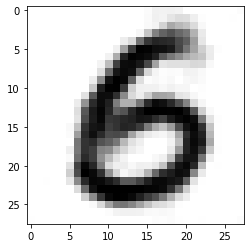

madry_l2_5_small_VGG_0
tensor([[0.7733, 0.0943, 0.2483, 0.6378, 0.1967, 0.7167, 0.0912, 0.2553, 1.1766,
         0.3829]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([17.2287], device='cuda:0')
tensor([0.], device='cuda:0')


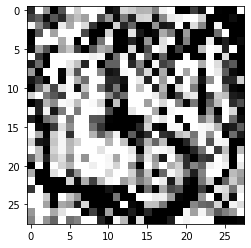

madry_l2_5_small_VGG_3
tensor([[2.5535, 0.5497, 0.1211, 0.7188, 0.3626, 1.2395, 0.1878, 0.5483, 1.1964,
         0.4105]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([16.7742], device='cuda:0')
tensor([0.], device='cuda:0')


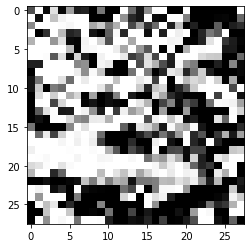

madry_l2_5_small_VGG_negative_0
tensor([[0.9918, 0.5527, 0.0824, 0.5060, 0.1197, 1.6822, 0.2635, 0.1658, 0.9941,
         0.2034]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([15.2193], device='cuda:0')
tensor([0.], device='cuda:0')


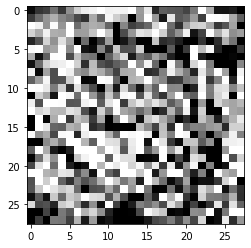

madry_l2_5_small_VGG_negative_9
tensor([[2.9641, 1.2951, 0.2482, 0.3899, 0.5295, 1.4397, 0.2495, 0.3274, 1.4214,
         0.3130]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([14.9460], device='cuda:0')
tensor([0.], device='cuda:0')


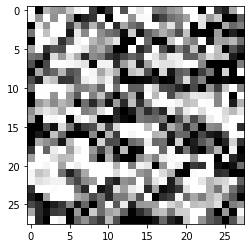

madry_l2_6_schott_VAE_5
tensor([[0.0165, 0.0026, 0.0091, 0.0150, 0.0331, 1.4619, 0.1056, 0.0199, 0.0271,
         0.0525]], device='cuda:0')
[0.        0.        0.        0.        0.        0.7589334 0.
 0.        0.        0.       ]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
tensor([0.2205], device='cuda:0')
tensor([0.7589], device='cuda:0')


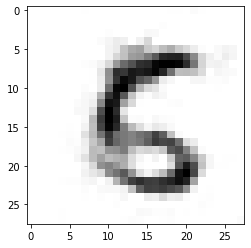

madry_l2_6_schott_VAE_8
tensor([[6.6529e-03, 1.8013e-03, 2.5774e-02, 1.9784e-02, 1.3536e-02, 4.5025e-02,
         1.2239e-01, 9.1969e-04, 1.5360e+00, 1.9586e-02]], device='cuda:0')
[0.        0.        0.        0.        0.        0.        0.
 0.        0.8617893 0.       ]
[0.   0.   0.   0.   0.   0.   0.75 0.   0.25 0.  ]
tensor([0.1691], device='cuda:0')
tensor([0.8618], device='cuda:0')


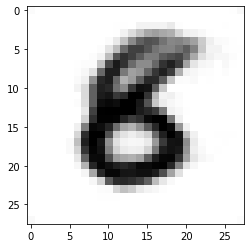

madry_l2_6_small_VGG_3
tensor([[0.2914, 0.0732, 0.9917, 0.3757, 0.2632, 0.1814, 0.3427, 0.0883, 0.6278,
         0.1707]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([11.1569], device='cuda:0')
tensor([0.], device='cuda:0')


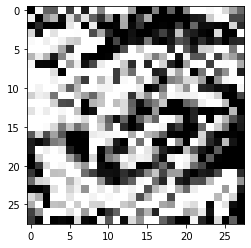

madry_l2_6_small_VGG_5
tensor([[0.6398, 0.0796, 0.7510, 0.4304, 0.8682, 0.8896, 0.1738, 0.0670, 0.9735,
         0.4528]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([13.7061], device='cuda:0')
tensor([0.], device='cuda:0')


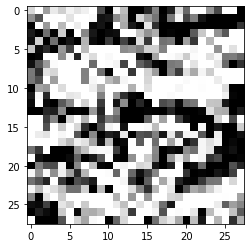

madry_l2_6_small_VGG_negative_2
tensor([[0.9043, 0.0624, 0.2468, 0.1383, 0.2498, 0.8395, 0.5501, 0.1306, 0.4301,
         0.1688]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([12.7521], device='cuda:0')
tensor([0.], device='cuda:0')


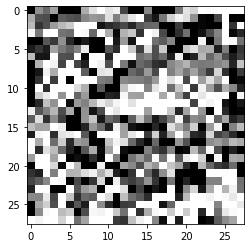

madry_l2_6_small_VGG_negative_3
tensor([[0.4452, 0.0652, 0.4430, 0.2359, 0.1622, 0.5633, 0.1638, 0.0455, 0.7833,
         0.0896]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([12.5345], device='cuda:0')
tensor([0.], device='cuda:0')


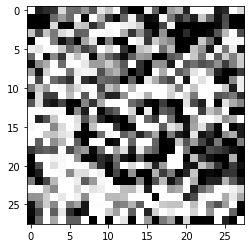

madry_l2_7_schott_VAE_1
tensor([[0.0415, 1.5059, 0.0702, 0.0270, 0.1312, 0.0031, 0.0115, 0.9134, 0.0198,
         0.0214]], device='cuda:0')
[0.         0.5677337  0.         0.         0.         0.
 0.         0.46935505 0.         0.        ]
[0.   0.25 0.   0.   0.   0.   0.   0.   0.   0.  ]
tensor([0.3161], device='cuda:0')
tensor([0.5677], device='cuda:0')


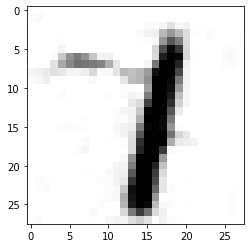

madry_l2_7_schott_VAE_4
tensor([[0.0195, 0.0321, 0.0134, 0.0157, 2.0173, 0.0490, 0.0348, 0.0466, 0.0040,
         0.0895]], device='cuda:0')
[0.        0.        0.        0.        0.6189907 0.        0.
 0.        0.        0.       ]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
tensor([0.2905], device='cuda:0')
tensor([0.6190], device='cuda:0')


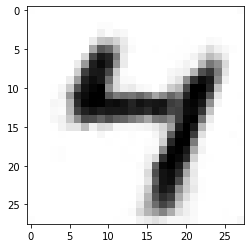

madry_l2_7_small_VGG_8
tensor([[2.2920, 0.3310, 0.5755, 0.7821, 0.0599, 0.4294, 1.0999, 0.6179, 0.6595,
         0.0698]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([13.6281], device='cuda:0')
tensor([0.], device='cuda:0')


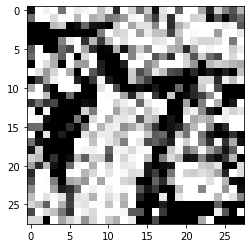

madry_l2_7_small_VGG_9
tensor([[1.3654, 0.2263, 0.5056, 1.4349, 0.2084, 1.5579, 0.3753, 0.4360, 0.8744,
         0.1850]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([15.1159], device='cuda:0')
tensor([0.], device='cuda:0')


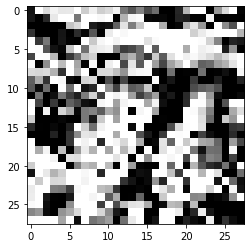

madry_l2_7_small_VGG_negative_3
tensor([[1.8619, 0.4635, 1.0760, 1.3428, 0.1414, 1.1640, 0.6227, 0.6789, 0.9685,
         0.3182]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([15.9595], device='cuda:0')
tensor([0.], device='cuda:0')


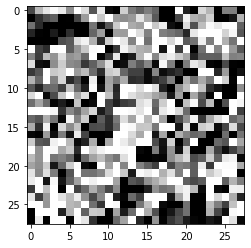

madry_l2_7_small_VGG_negative_8
tensor([[1.2683, 1.0191, 0.6853, 0.7500, 0.1712, 0.8212, 0.4635, 0.5278, 0.5881,
         0.2810]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tensor([15.4008], device='cuda:0')
tensor([0.], device='cuda:0')


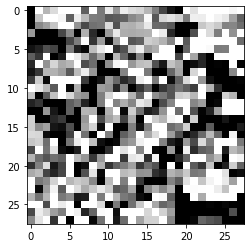

madry_l2_8_schott_VAE_2
tensor([[0.0178, 0.0106, 1.7761, 0.1754, 0.0038, 0.0138, 0.0483, 0.0666, 0.1217,
         0.0058]], device='cuda:0')
[0.         0.         0.12056881 0.         0.         0.
 0.         0.         0.         0.        ]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
tensor([0.5397], device='cuda:0')
tensor([0.1206], device='cuda:0')


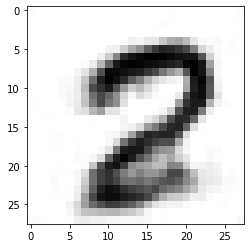

madry_l2_8_schott_VAE_6
tensor([[0.0609, 0.0230, 0.0965, 0.0283, 0.1531, 0.0675, 1.0043, 0.0132, 0.7413,
         0.0389]], device='cuda:0')
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
tensor([0.6161], device='cuda:0')
tensor([0.], device='cuda:0')


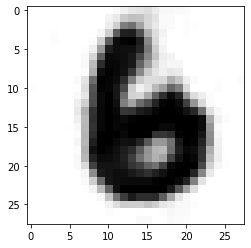

In [14]:
from PIL import Image, ImageOps

img_sm = np.unique(df_sm['image'])

num_images = 20  # len(img_sm)

for i in range(650,750):
    
    img_name = img_sm[i]
    print(img_name)
    
    ind = np.where(img_names == img_name)
    print(outPRED[ind])
    
    print(df_sm[df_sm['image'] == img_name].predictions.to_numpy())
    
    print(df_sm[df_sm['image'] == img_name].rating.to_numpy())
    
    print(L_recon_all[ind])
    print(c_factor[ind])
    
    img_path = img_folder + img_name + '.png'
    img =  (np.array(ImageOps.grayscale(Image.open(img_path))) / 255.0) #  cv2.imread(path, 0)
    plt.imshow(img, cmap = 'gray')
    plt.show()